# Start


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import anderson, iqr, skew, zscore
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import (
    RFE,
    SelectFromModel,
    SelectKBest,
    VarianceThreshold,
    f_classif,
    f_regression,
    mutual_info_classif,
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    MinMaxScaler,
    PowerTransformer,
    QuantileTransformer,
    StandardScaler,
)
from sklearn.svm import SVR, LinearSVC

In [2]:
file_path: str = "../dataset"
files: tuple[str, ...] = ("connections", "devices", "processes", "profiles")

dataset: dict[str, pd.DataFrame] = {}
for file in files:
    dataset[file] = pd.read_csv(f"{file_path}/{file}.csv", sep="\t")
    dataset[file] = dataset[file].drop_duplicates()

In [3]:
df = pd.merge(dataset["connections"], dataset["processes"], on=["imei", "ts", "mwra"], how="inner")
df["ts"] = pd.to_datetime(df.ts)

# 2.1


## A

### **Zadanie:** Dáta si rozdeľte na trénovaciu a testovaciu množinu podľa vami preddefinovaného pomeru. Ďalej pracujte len s trénovacím datasetom.


In [4]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

## B

### **Zadanie:** Transformujte dáta na vhodný formát pre ML t.j. jedno pozorovanie musí byť opísané jedným riadkom a každý atribút musí byť v numerickom formáte (encoding). Iteratívne integrujte aj kroky v predspracovaní dát z prvej fázy (missing values, outlier detection) ako celok.


In [5]:
duplicate_ts = train_data.duplicated(subset="ts").any()
print(f"Are there any duplicate timestamps? {duplicate_ts}")

Are there any duplicate timestamps? False


-   There are no duplicates in datetime, therefore every observation is in one row


In [6]:
train_data.dtypes.value_counts()

float64           31
datetime64[ns]     1
int64              1
Name: count, dtype: int64

-   All columns are in numerical format


In [7]:
null_counts = train_data.isnull().sum()
null_counts = null_counts[null_counts > 0]
null_counts

Series([], dtype: int64)

-   There are no missing values


Graph showing the boxplot and outliers of the dataset.


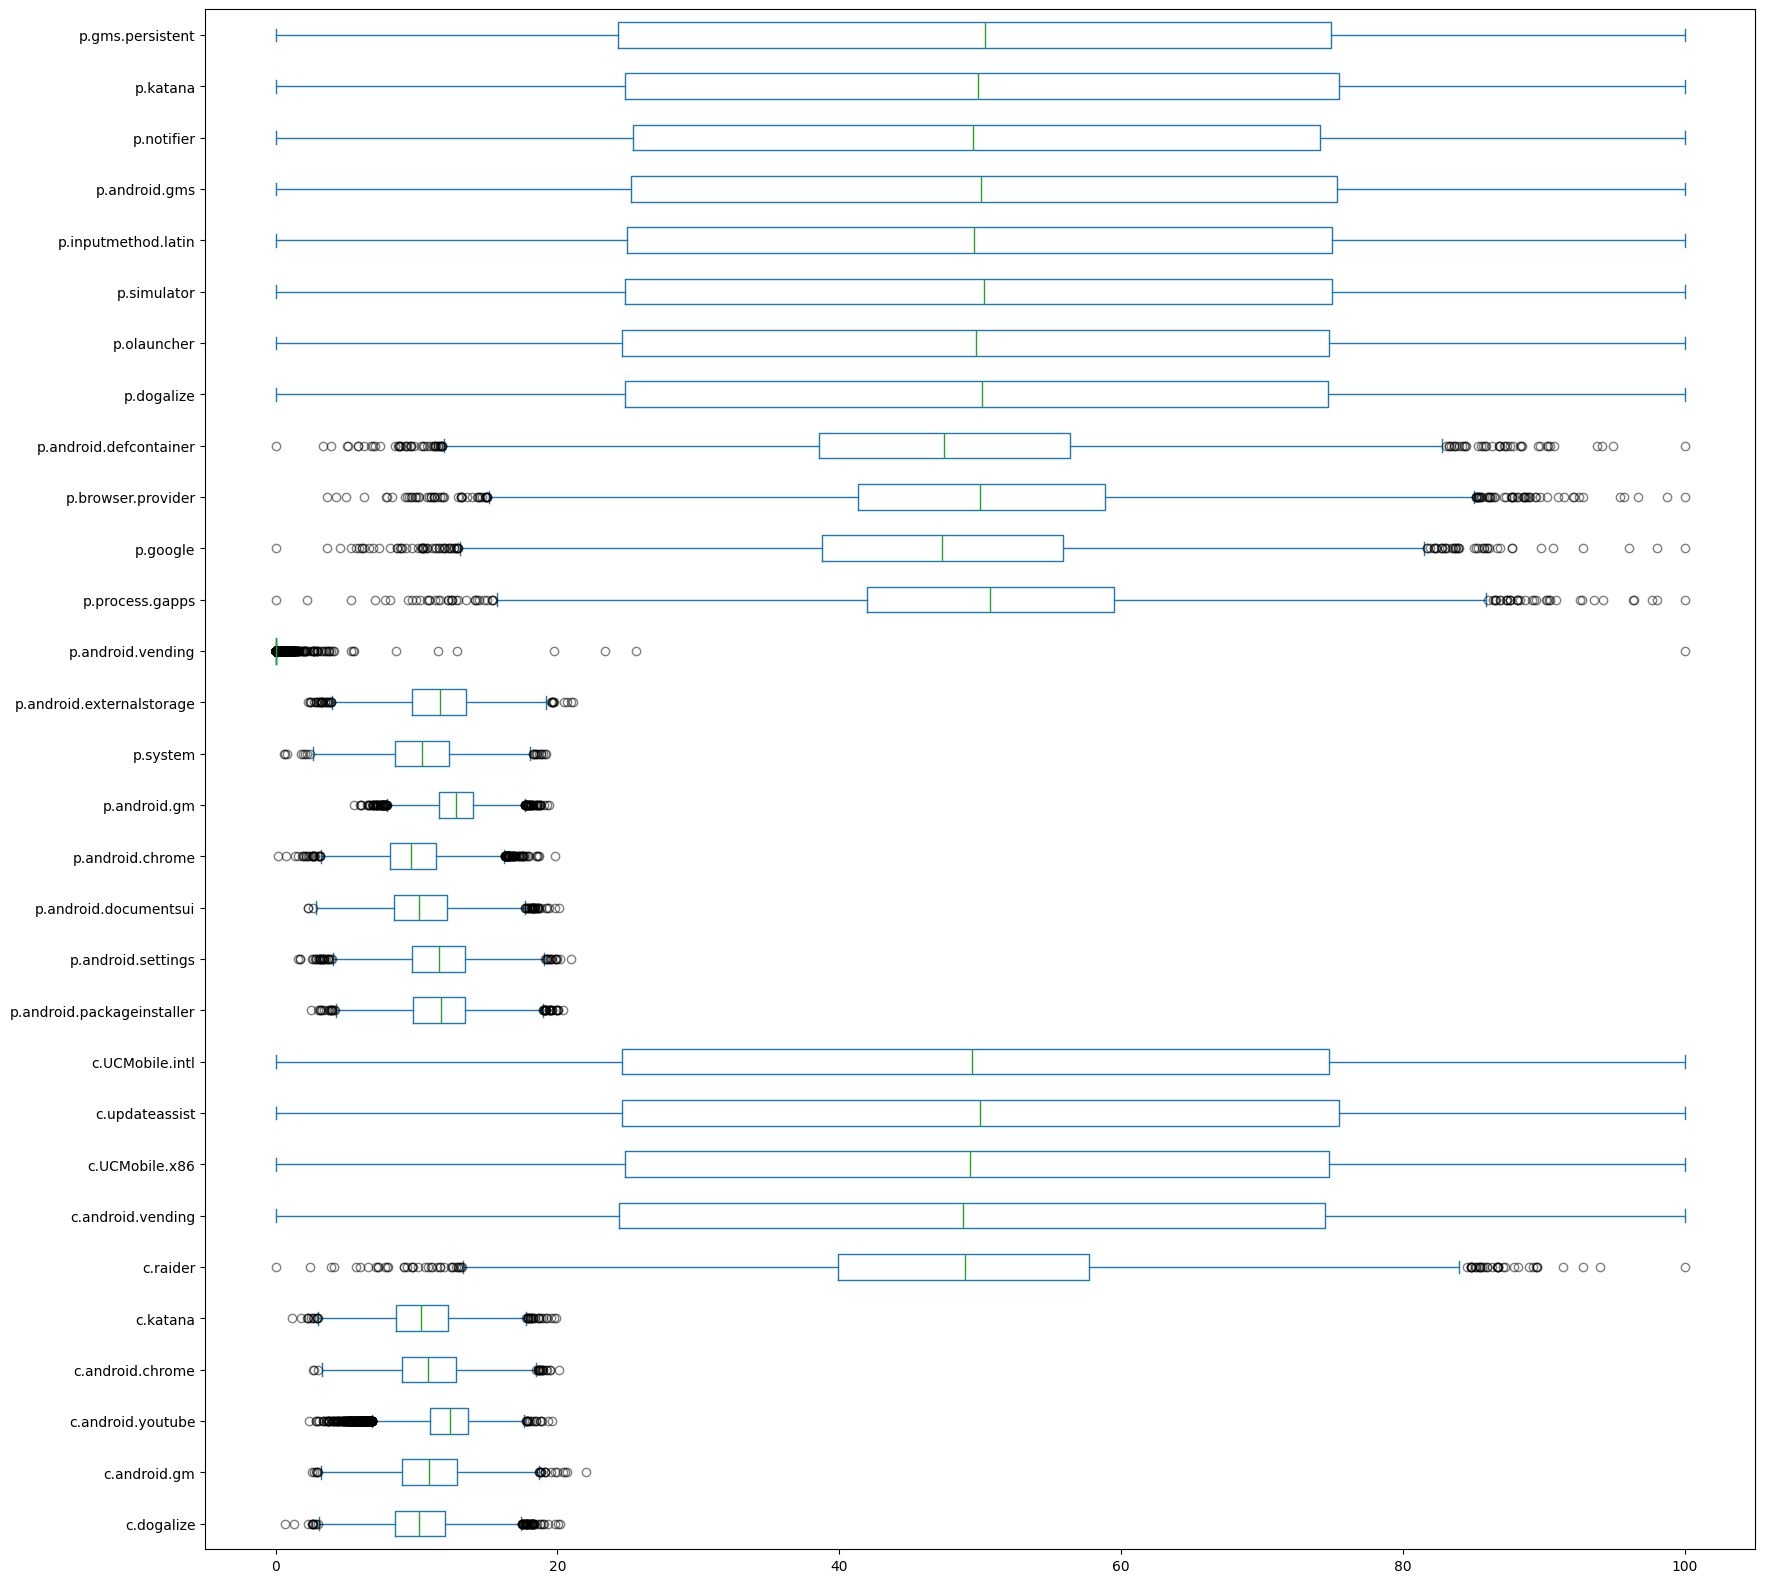

In [8]:
train_data.iloc[:, 3:].plot(
    kind="box", vert=False, figsize=(20, 20), flierprops=dict(marker="o", color="r", alpha=0.5)
)
plt.show()

In [9]:
norm_distribution = True

for col in train_data.columns[2:]:
    result = anderson(train_data[col], dist="norm")

    if not result.fit_result.success:
        norm_distribution = False
        print(f"{col} is not normally distributed")

if norm_distribution:
    print("All columns are normally distributed")

All columns are normally distributed


We are going to use Z-score (3), to detect outliers.


In [10]:
number_of_rows_before = train_data.shape[0]
print(f"Number of rows before removing outliers: {number_of_rows_before}")

train_data = train_data[(np.abs(zscore(train_data.iloc[:, 3:])) < 3).all(axis=1)]

number_of_rows_after = train_data.shape[0]
print(f"Number of rows after removing outliers: {number_of_rows_after}")
print(f"Number of rows removed: {number_of_rows_before - number_of_rows_after}")
print(
    f"Percentage of rows removed: {(number_of_rows_before - number_of_rows_after) / number_of_rows_before * 100:.2f}%"
)

Number of rows before removing outliers: 11943
Number of rows after removing outliers: 11466
Number of rows removed: 477
Percentage of rows removed: 3.99%


-   Removing 4% of the is ok, therefore we are not going to use methods to replace outliers


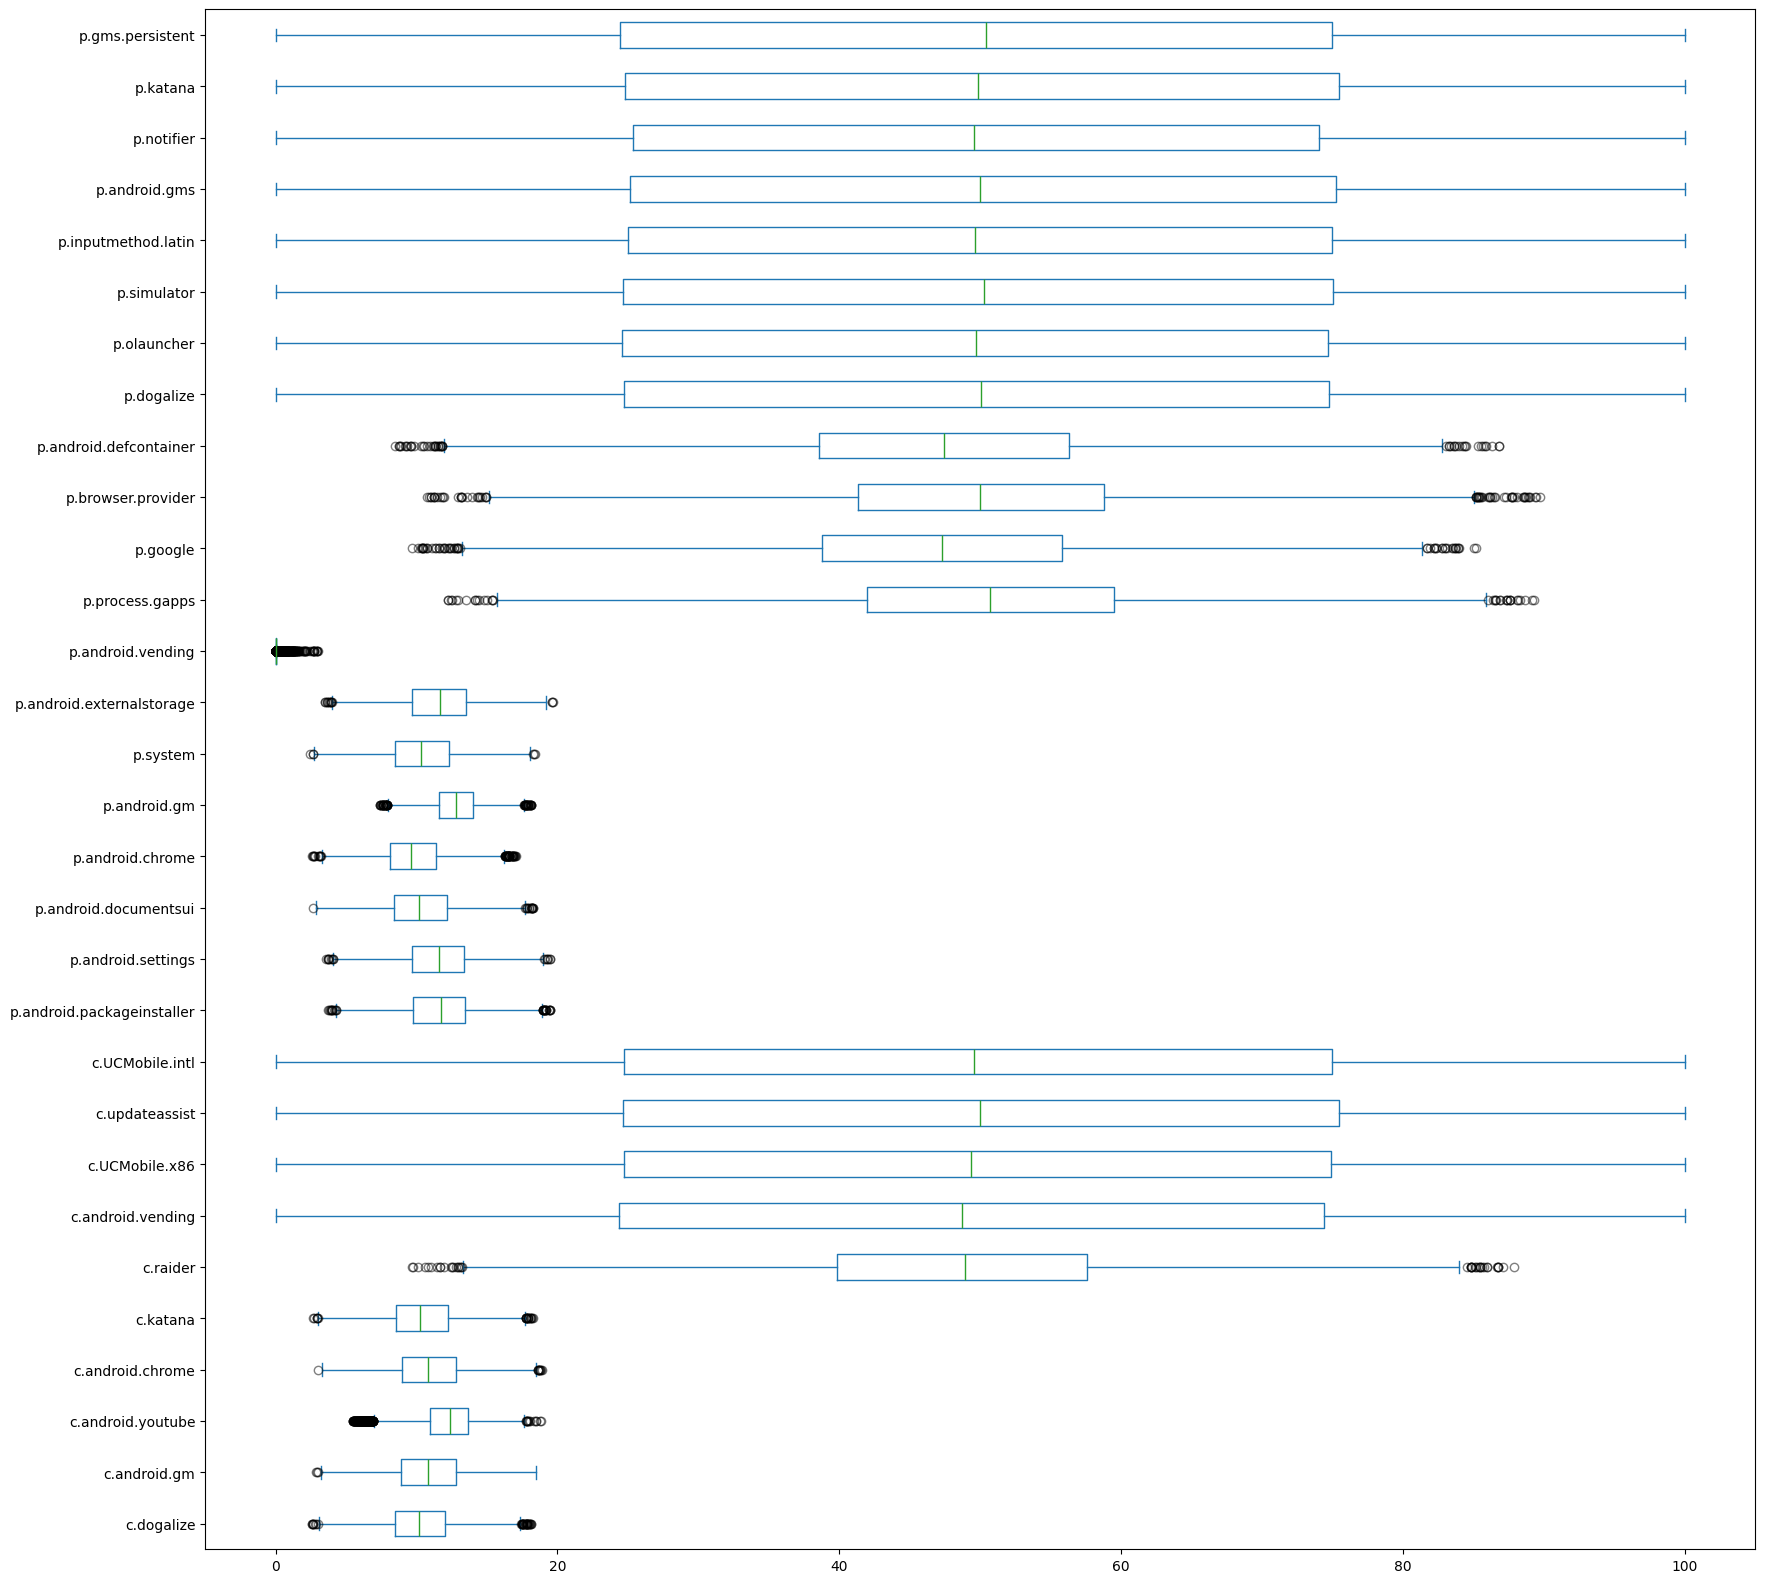

In [11]:
train_data.iloc[:, 3:].plot(
    kind="box", vert=False, figsize=(20, 20), flierprops=dict(marker="o", color="r", alpha=0.5)
)
plt.show()

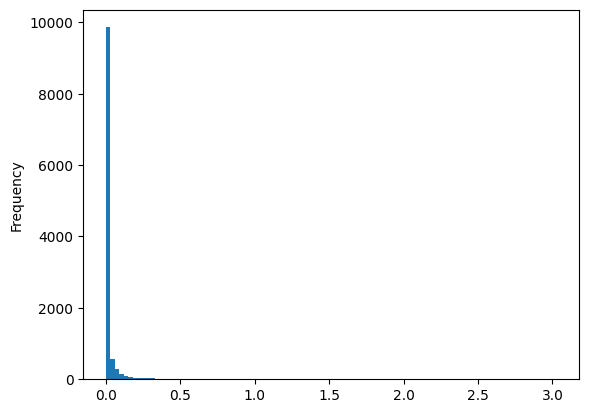

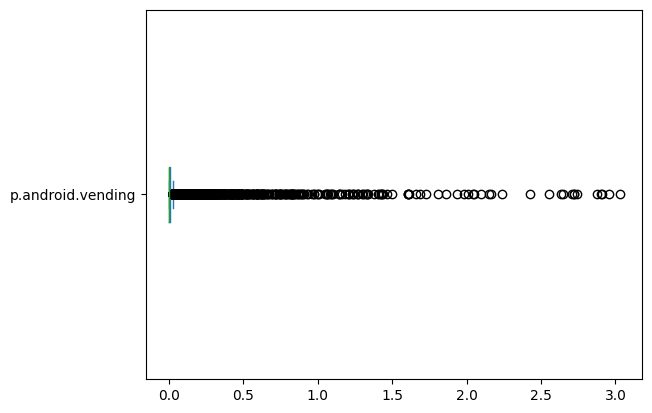

In [12]:
train_data["p.android.vending"].plot(kind="hist", bins=100)
plt.show()
train_data["p.android.vending"].plot(kind="box", vert=False)
plt.show()

In [13]:
def identify_outliers(a):
    lower = a.quantile(0.25) - 1.5 * iqr(a)
    upper = a.quantile(0.75) + 1.5 * iqr(a)

    return a[(a > upper) | (a < lower)]


train_data_copy = train_data.copy()
outliers = train_data_copy[["p.android.vending"]].apply(identify_outliers)
train_data_copy = train_data_copy.drop(outliers.index)
print(f"Number of outliers: {train_data_copy[["p.android.vending"]].apply(identify_outliers).count().values[0]}")
print(
    f"Percentage of outliers: {train_data_copy[["p.android.vending"]].apply(identify_outliers).count().values[0] / train_data_copy.shape[0] * 100:.2f}%"
)

Number of outliers: 1183
Percentage of outliers: 12.23%


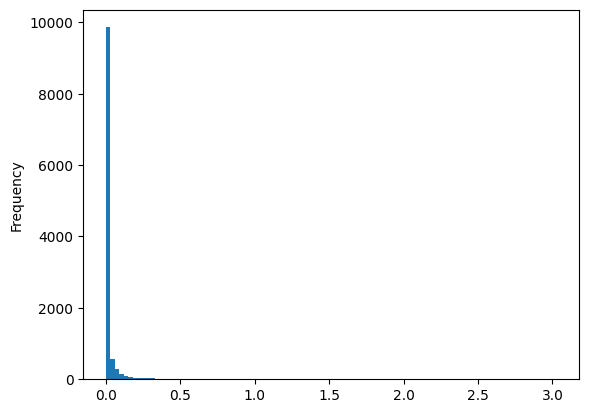

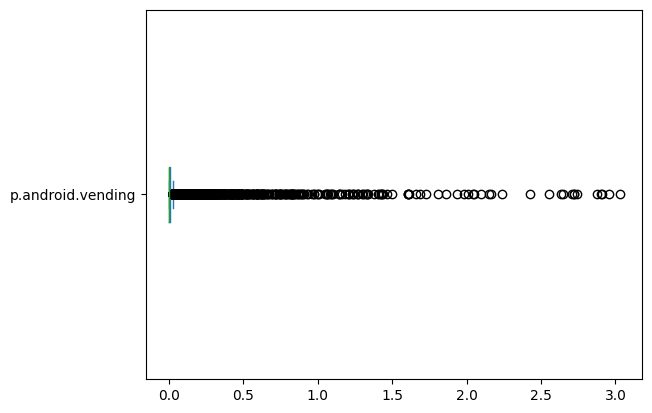

In [14]:
train_data["p.android.vending"].plot(kind="hist", bins=100)
plt.show()
train_data["p.android.vending"].plot(kind="box", vert=False)
plt.show()

-   In column **'p.android.vending'** there were too many outliers
-   We tried to remove them using 25% and 75% quantiles, but there was almost no noticeable difference
-   Using this we would remove 1183 (12.23%) rows which is quite substantial amount, therefore we decided not ot manipulate with outliers in this column


## C

### **Zadanie:** Transformujte atribúty dát pre strojové učenie podľa dostupných techník minimálne: scaling (2 techniky), transformers (2 techniky) a ďalšie. Cieľom je aby ste testovali efekty a vhodne kombinovali v dátovom pipeline (od časti 2.3 a v 3. fáze).


In [15]:
def skewness_type(skew_value: float) -> str:
    if skew_value <= -1:
        return "Highly Negative Skew"

    elif skew_value <= -0.5:
        return "Moderately Negative Skew"

    elif skew_value <= 0.5:
        return "Approximately Symmetric"

    elif skew_value <= 1:
        return "Moderately Positive Skew"

    return "Highly Positive Skew"


def kurtosis_type(kurtosis_value: float) -> str:
    if kurtosis_value < -1:
        return "Negative Kurtosis"

    elif kurtosis_value < -0.5:
        return "Moderately Negative Kurtosis"

    elif kurtosis_value < 0.5:
        return "Approximately Normal Kurtosis"

    elif kurtosis_value < 1:
        return "Moderately Positive Kurtosis"

    return "Positive Kurtosis"

In [16]:
columns = train_data.columns[3:].tolist()
skew_values = [skew(train_data[col]) for col in columns]
kurtosis_values = [train_data[col].kurtosis() for col in columns]

data = {
    "columns": columns,
    "skew": skew_values,
    "kurtosis": kurtosis_values,
}

shape_train_data = pd.DataFrame(data)

shape_train_data["result skew"] = shape_train_data["skew"].apply(skewness_type)
shape_train_data["result kurtosis"] = shape_train_data["kurtosis"].apply(kurtosis_type)
shape_train_data

,columns,skew,kurtosis,result skew,result kurtosis
0,c.dogalize,0.199147,-0.242746,Approximately Symmetric,Approximately Normal Kurtosis
1,c.android.gm,0.095776,-0.429023,Approximately Symmetric,Approximately Normal Kurtosis
2,c.android.youtube,-0.473942,0.208048,Approximately Symmetric,Approximately Normal Kurtosis
3,c.android.chrome,0.194469,-0.446646,Approximately Symmetric,Approximately Normal Kurtosis
4,c.katana,0.174743,-0.311146,Approximately Symmetric,Approximately Normal Kurtosis
5,c.raider,-0.006514,-0.182431,Approximately Symmetric,Approximately Normal Kurtosis
6,c.android.vending,0.036176,-1.192164,Approximately Symmetric,Negative Kurtosis
7,c.UCMobile.x86,0.013868,-1.210607,Approximately Symmetric,Negative Kurtosis
8,c.updateassist,-0.001241,-1.221359,Approximately Symmetric,Negative Kurtosis
9,c.UCMobile.intl,0.008864,-1.205477,Approximately Symmetric,Negative Kurtosis


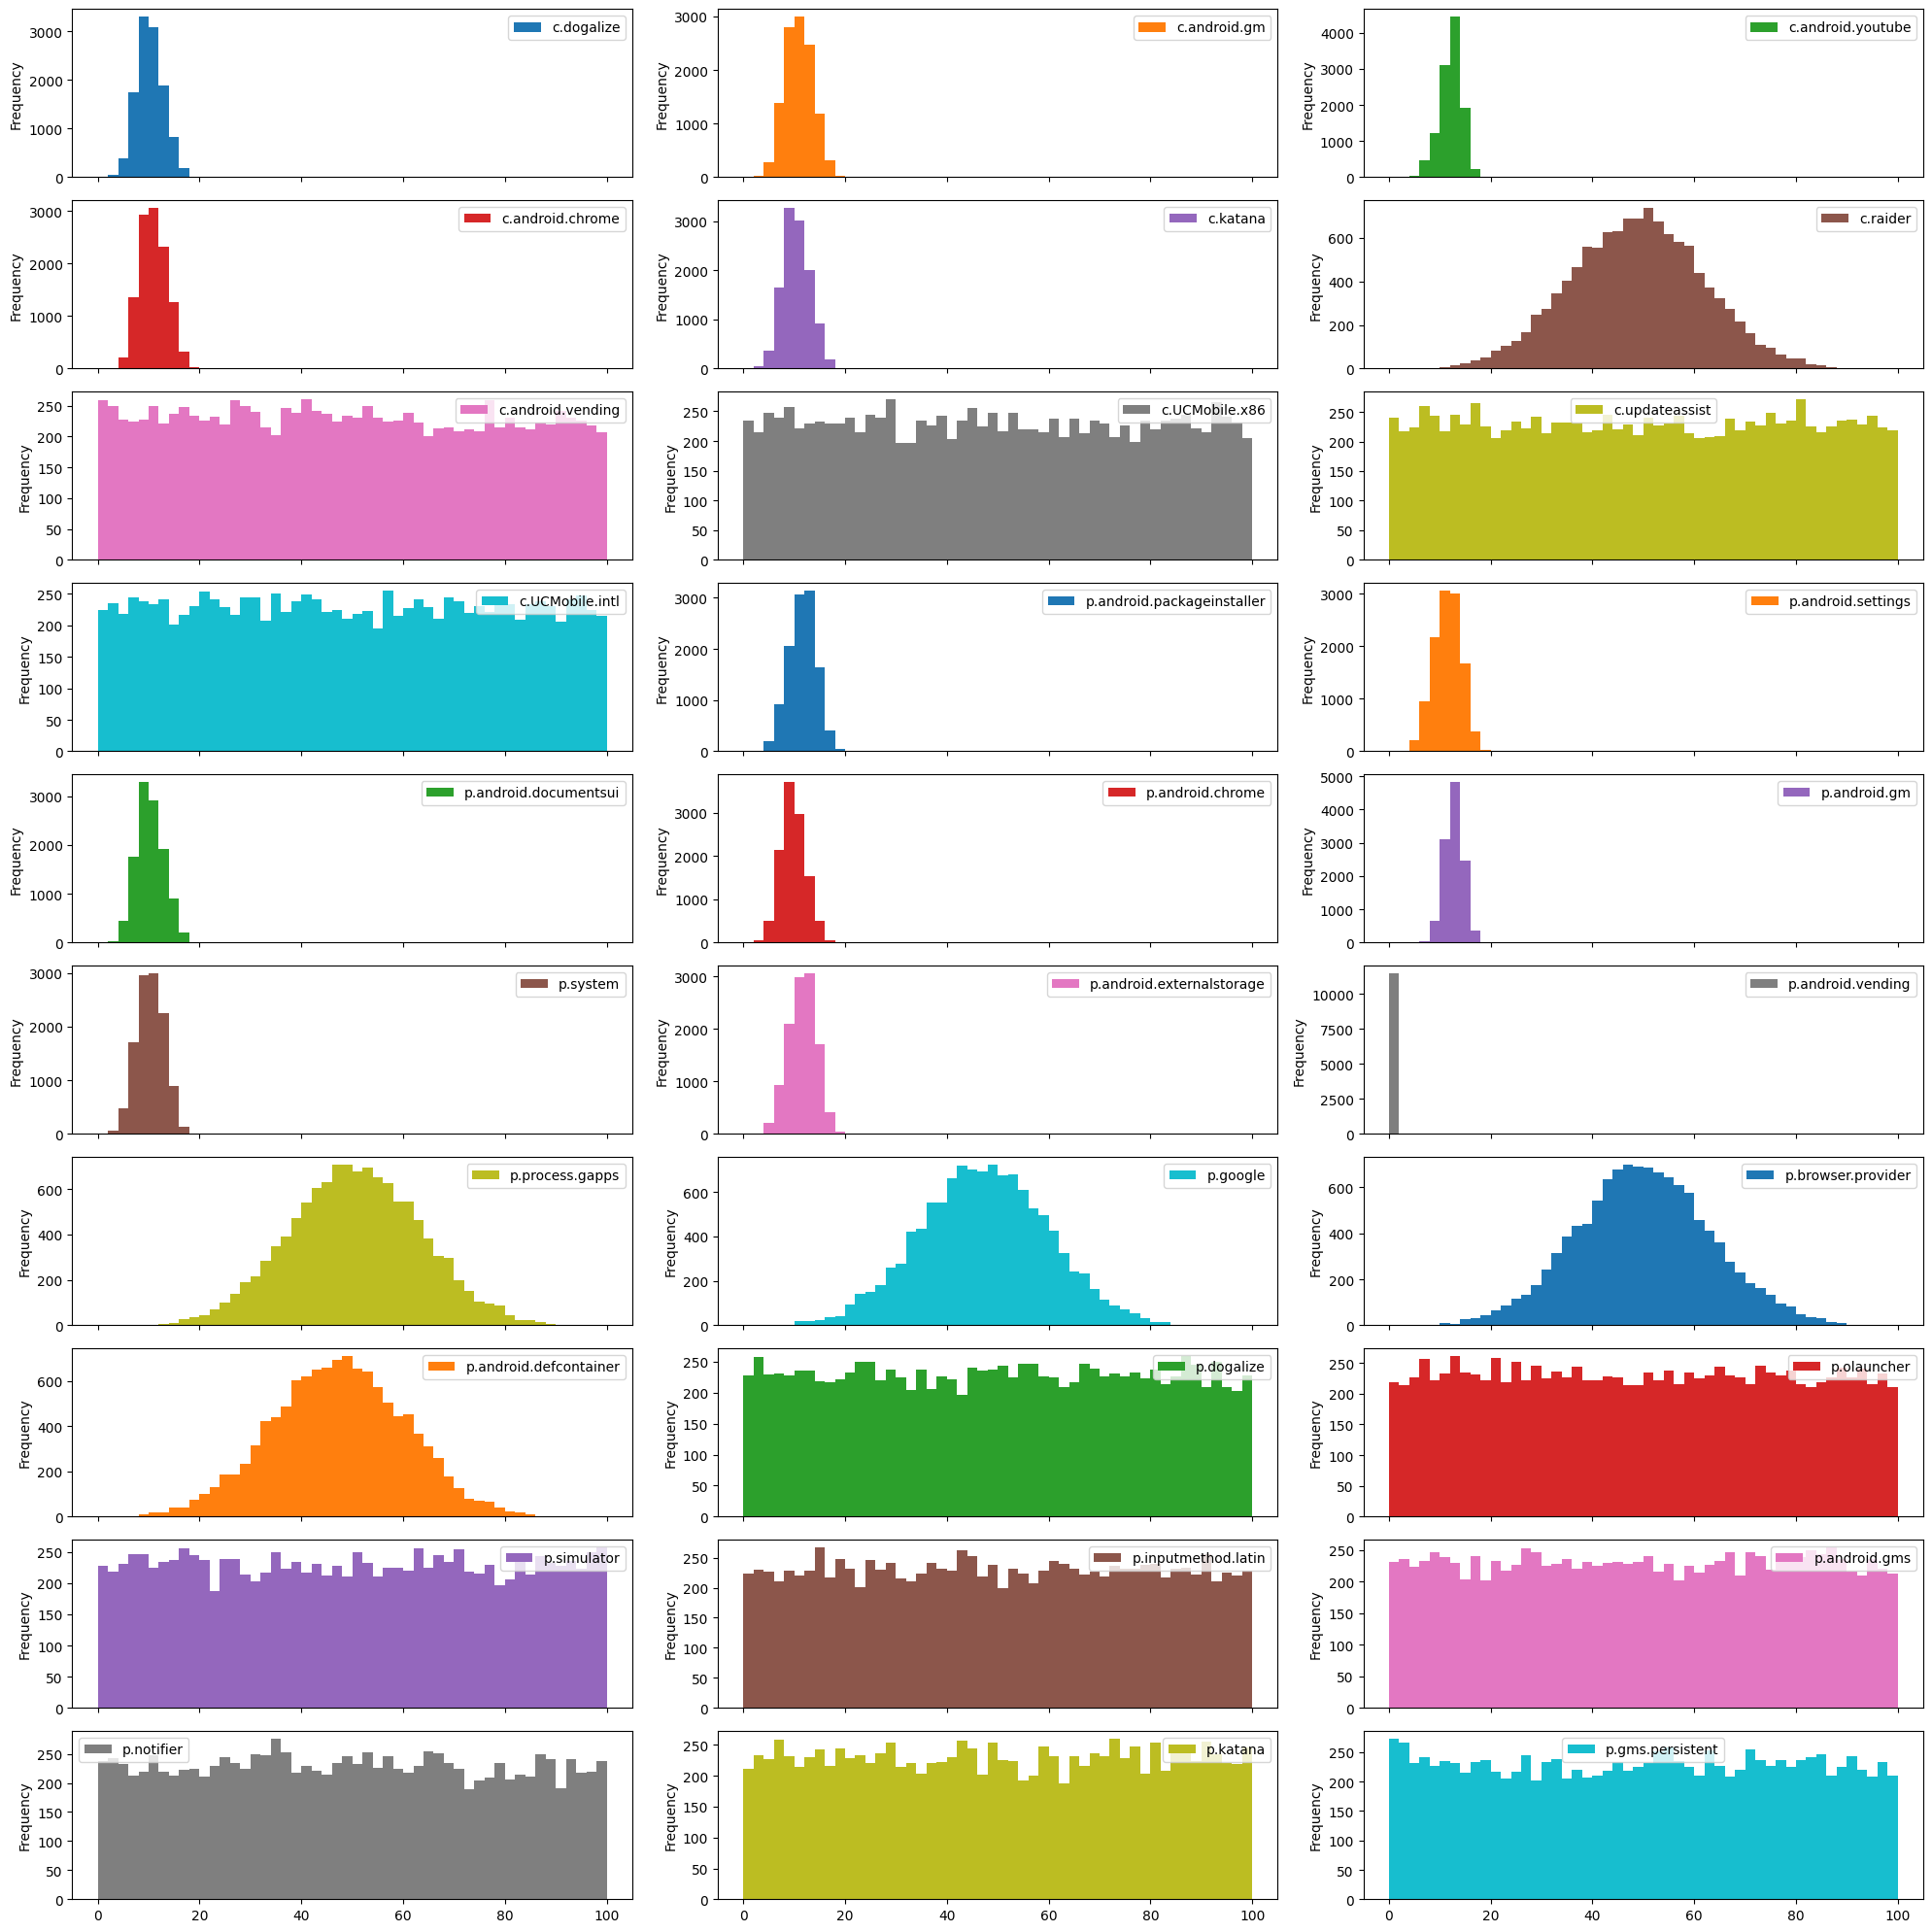

In [17]:
train_data.iloc[:, 3:].plot(kind="hist", bins=50, figsize=(20, 20), subplots=True, layout=(10, 3))
plt.tight_layout()
plt.show()

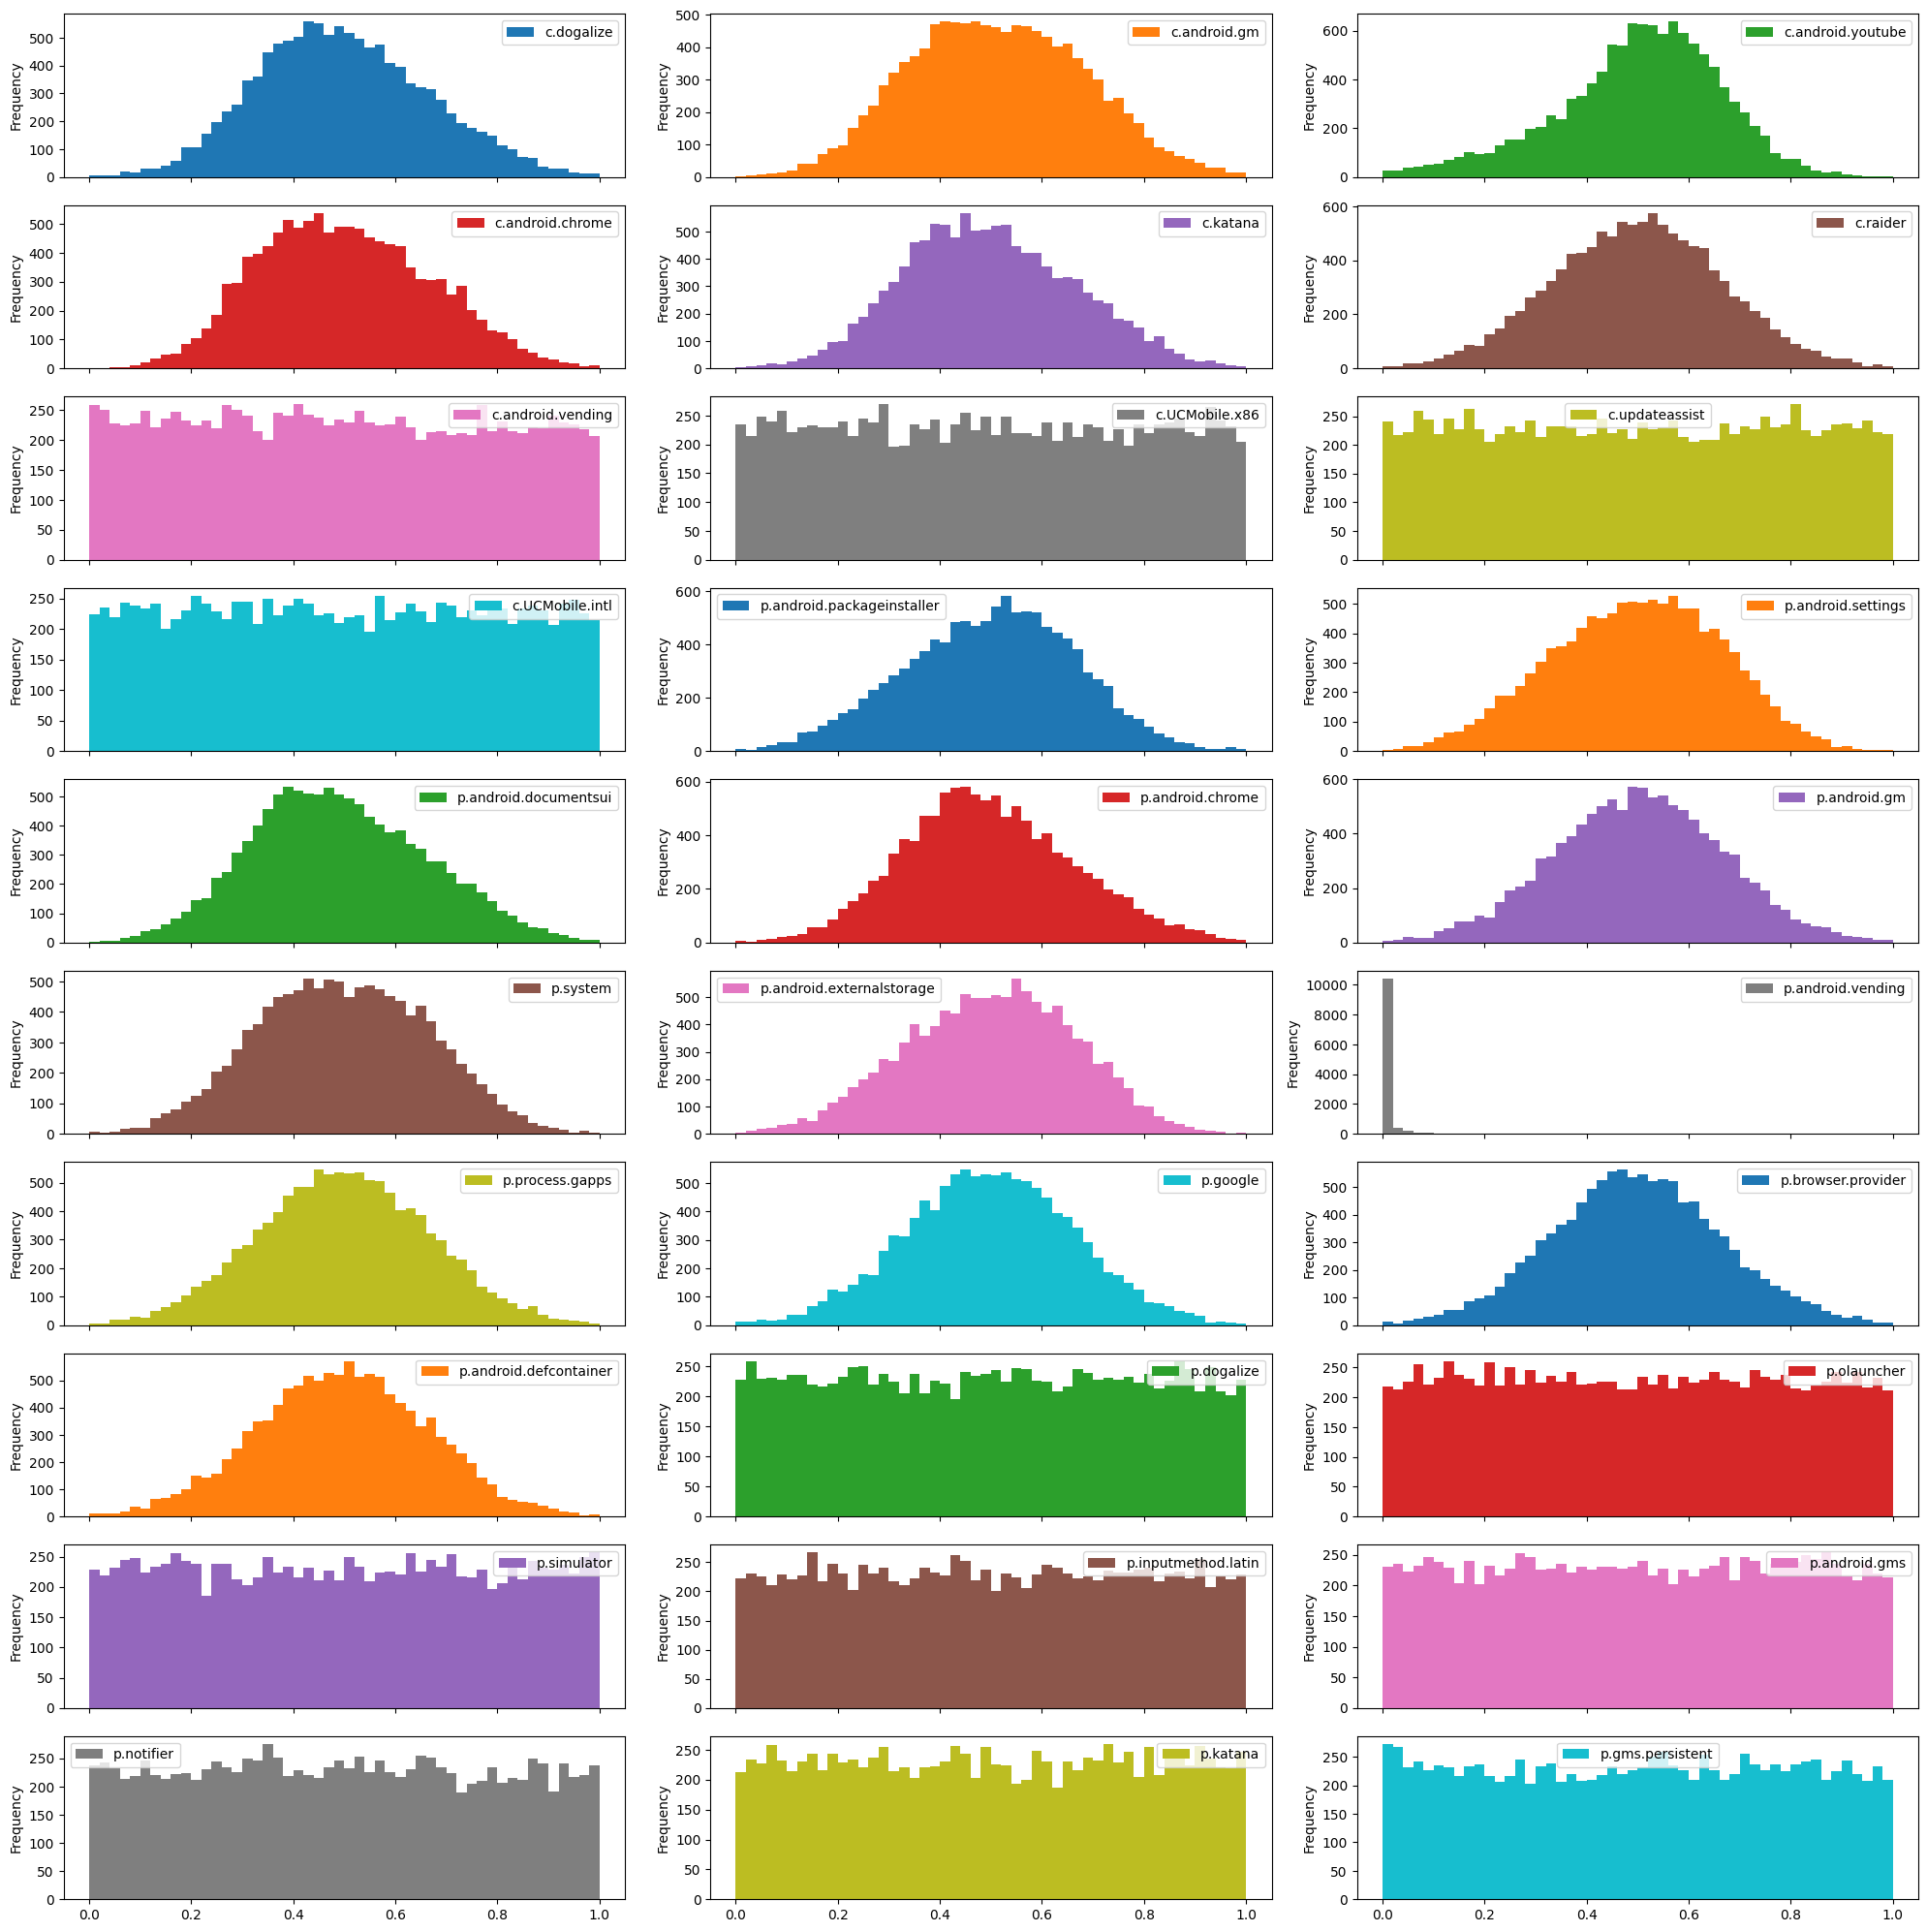

In [18]:
scaler = MinMaxScaler()
scaled_data_minmax = scaler.fit_transform(train_data.iloc[:, 3:])

scaled_data_minmax = pd.DataFrame(scaled_data_minmax, columns=train_data.columns[3:])
scaled_data_minmax.plot(kind="hist", bins=50, figsize=(20, 20), subplots=True, layout=(10, 3))
plt.tight_layout()
plt.show()

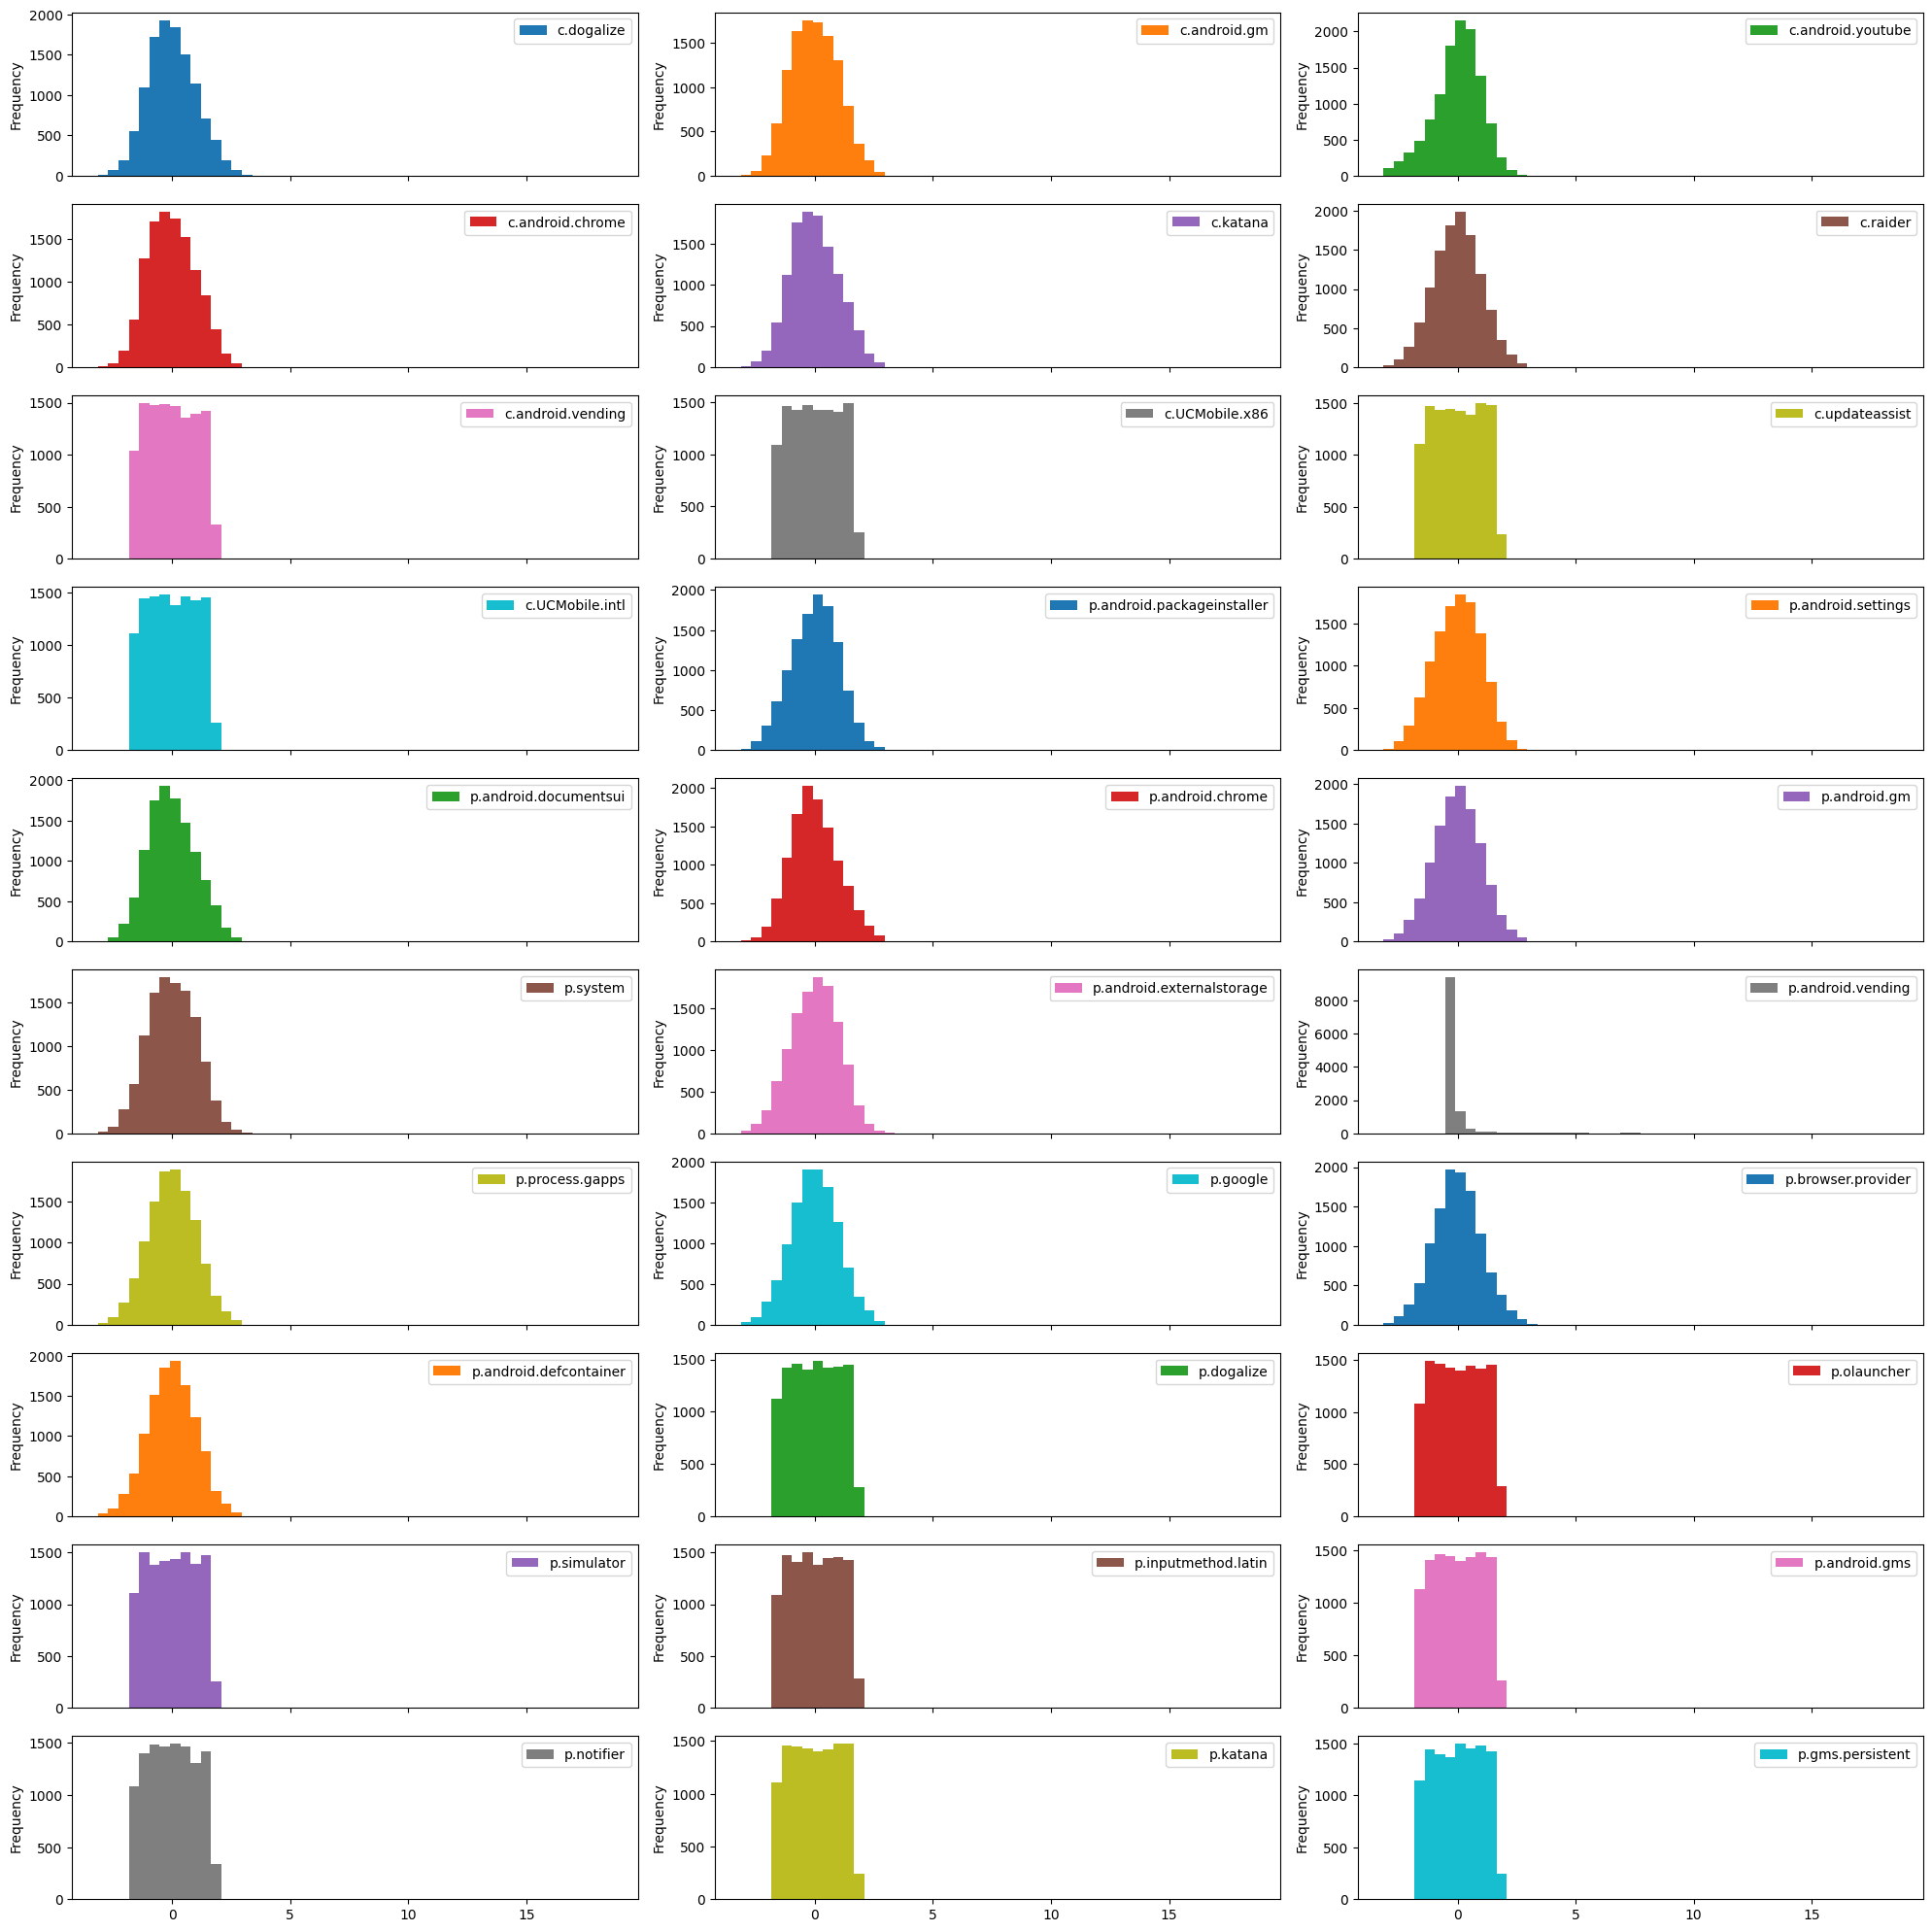

In [19]:
scaler = StandardScaler()
scaled_data_standard = scaler.fit_transform(train_data.iloc[:, 3:])

scaled_data_standard = pd.DataFrame(scaled_data_standard, columns=train_data.columns[3:])

scaled_data_standard.plot(kind="hist", bins=50, figsize=(20, 20), subplots=True, layout=(10, 3))
plt.tight_layout()
plt.show()

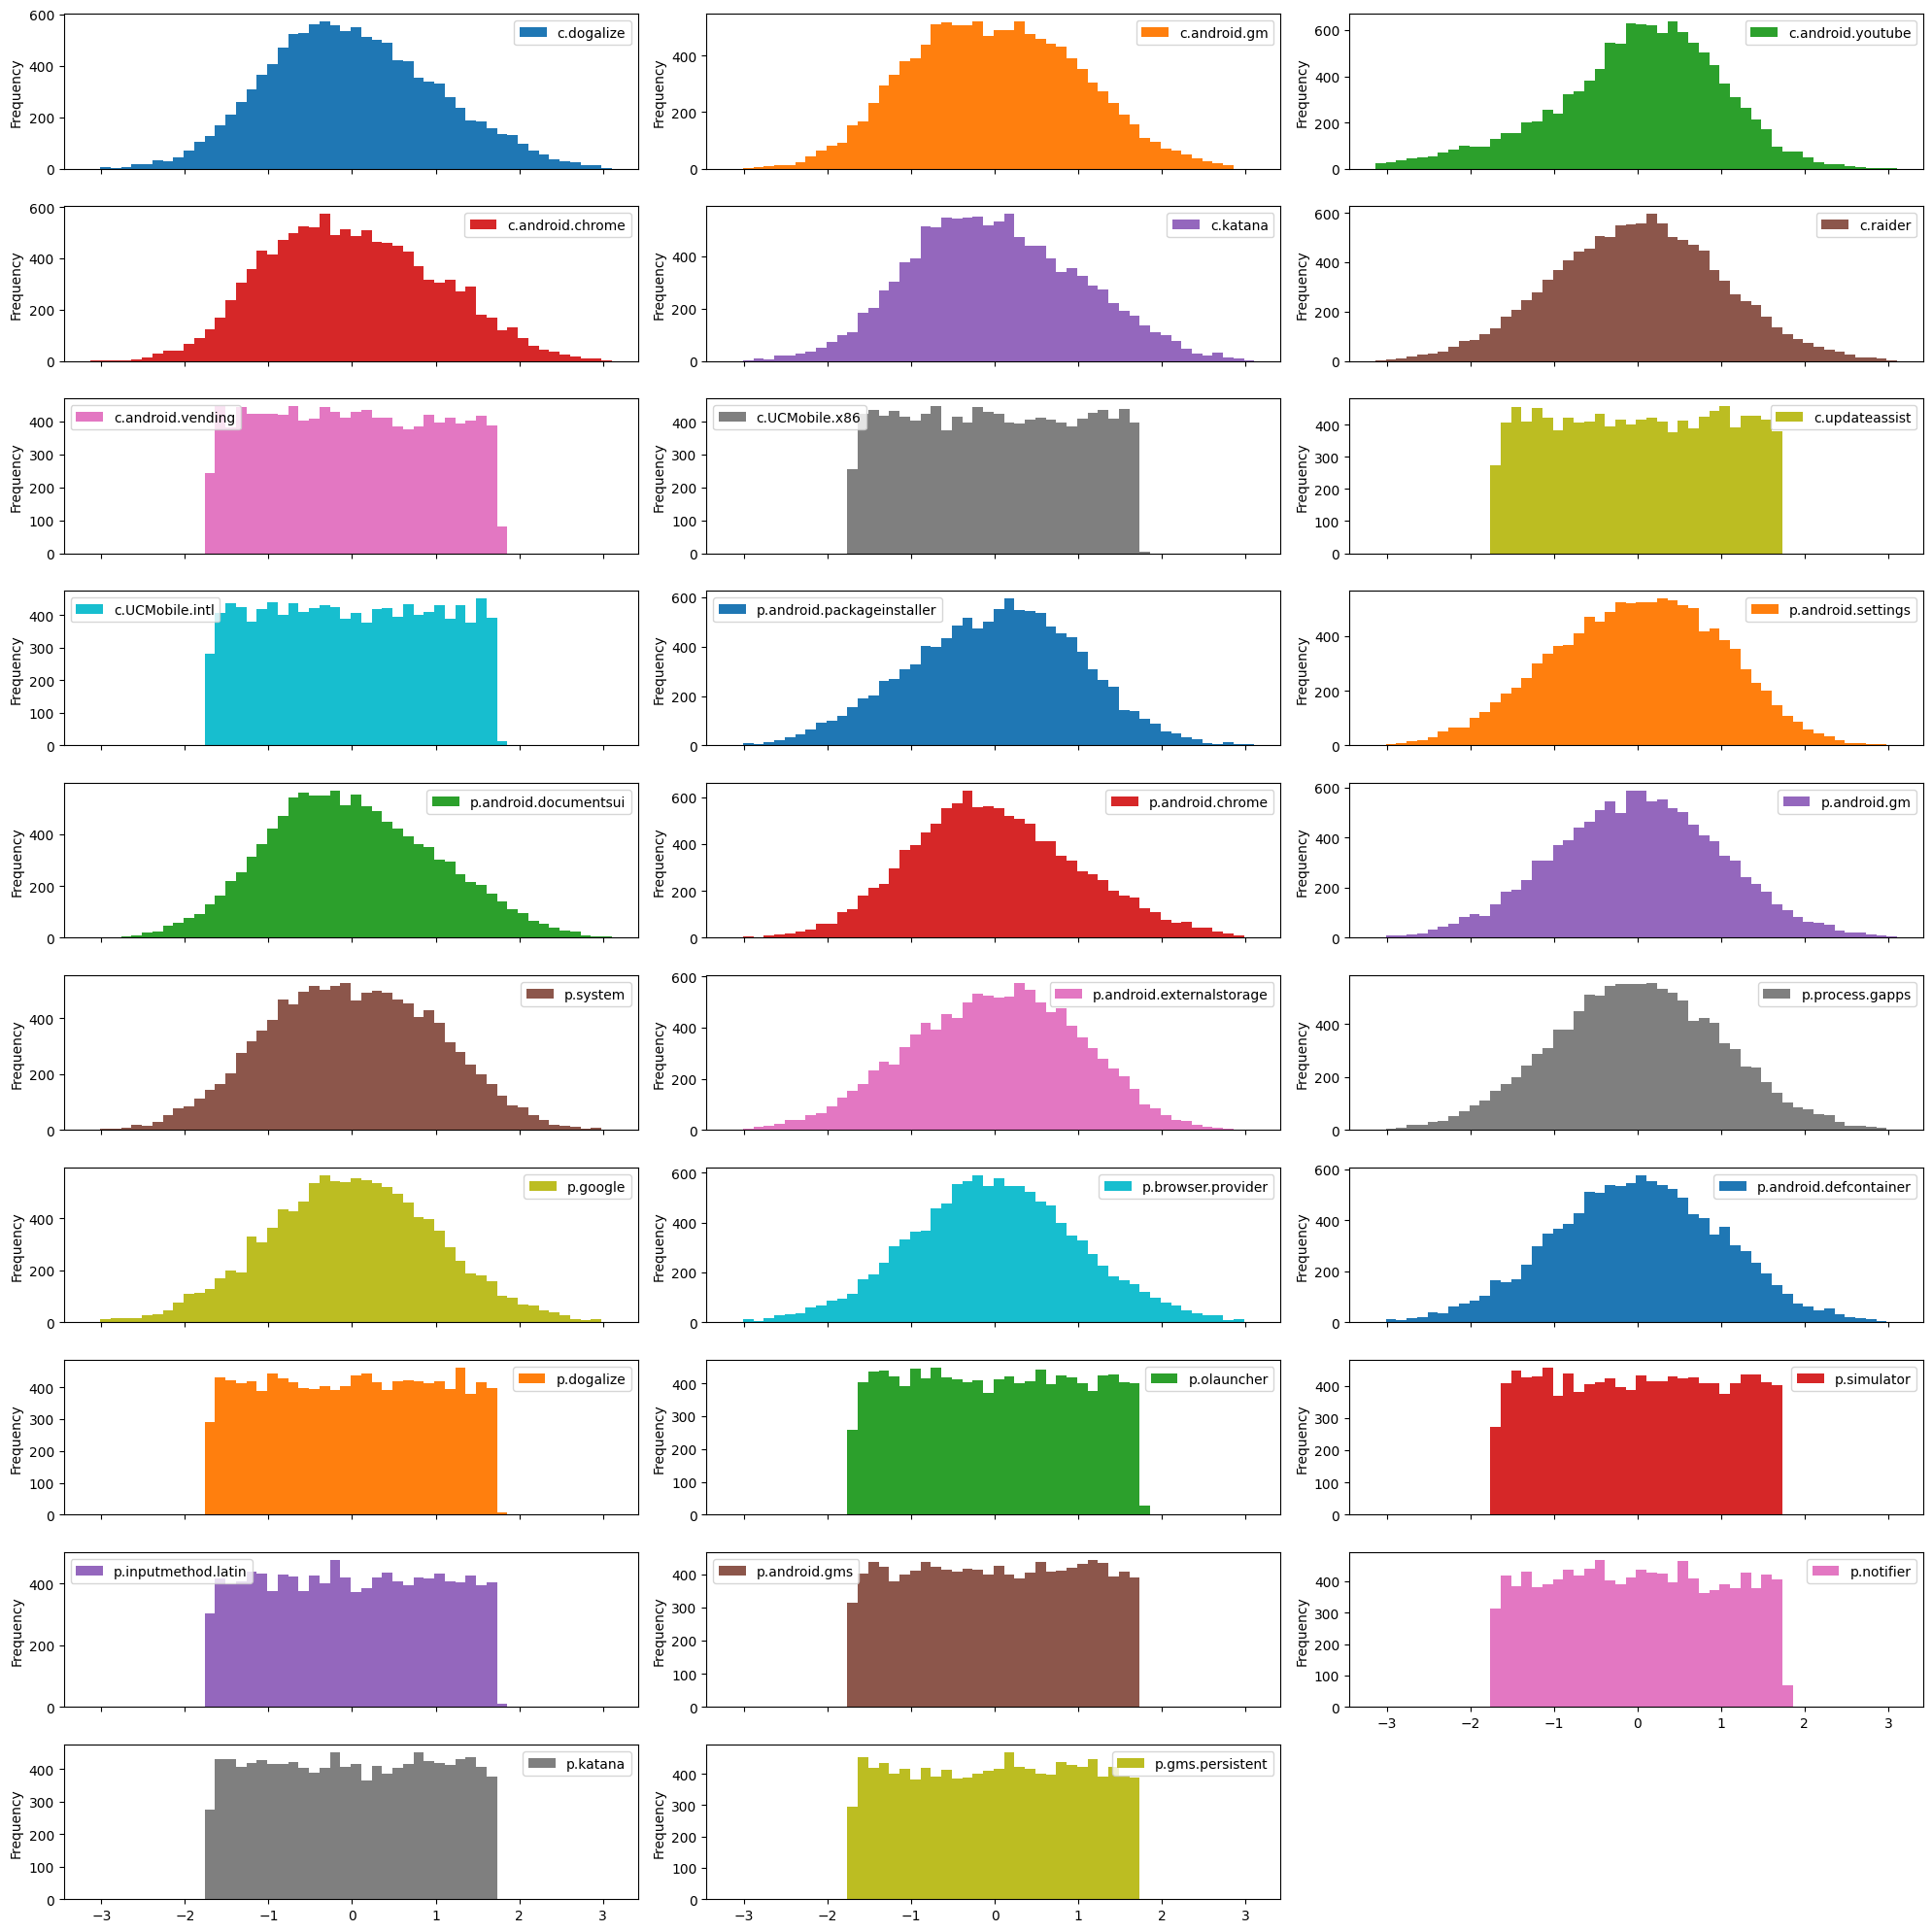

In [20]:
scaled_data_standard.drop(columns=["p.android.vending"]).plot(
    kind="hist", bins=50, figsize=(20, 20), subplots=True, layout=(10, 3)
)
plt.tight_layout()
plt.show()

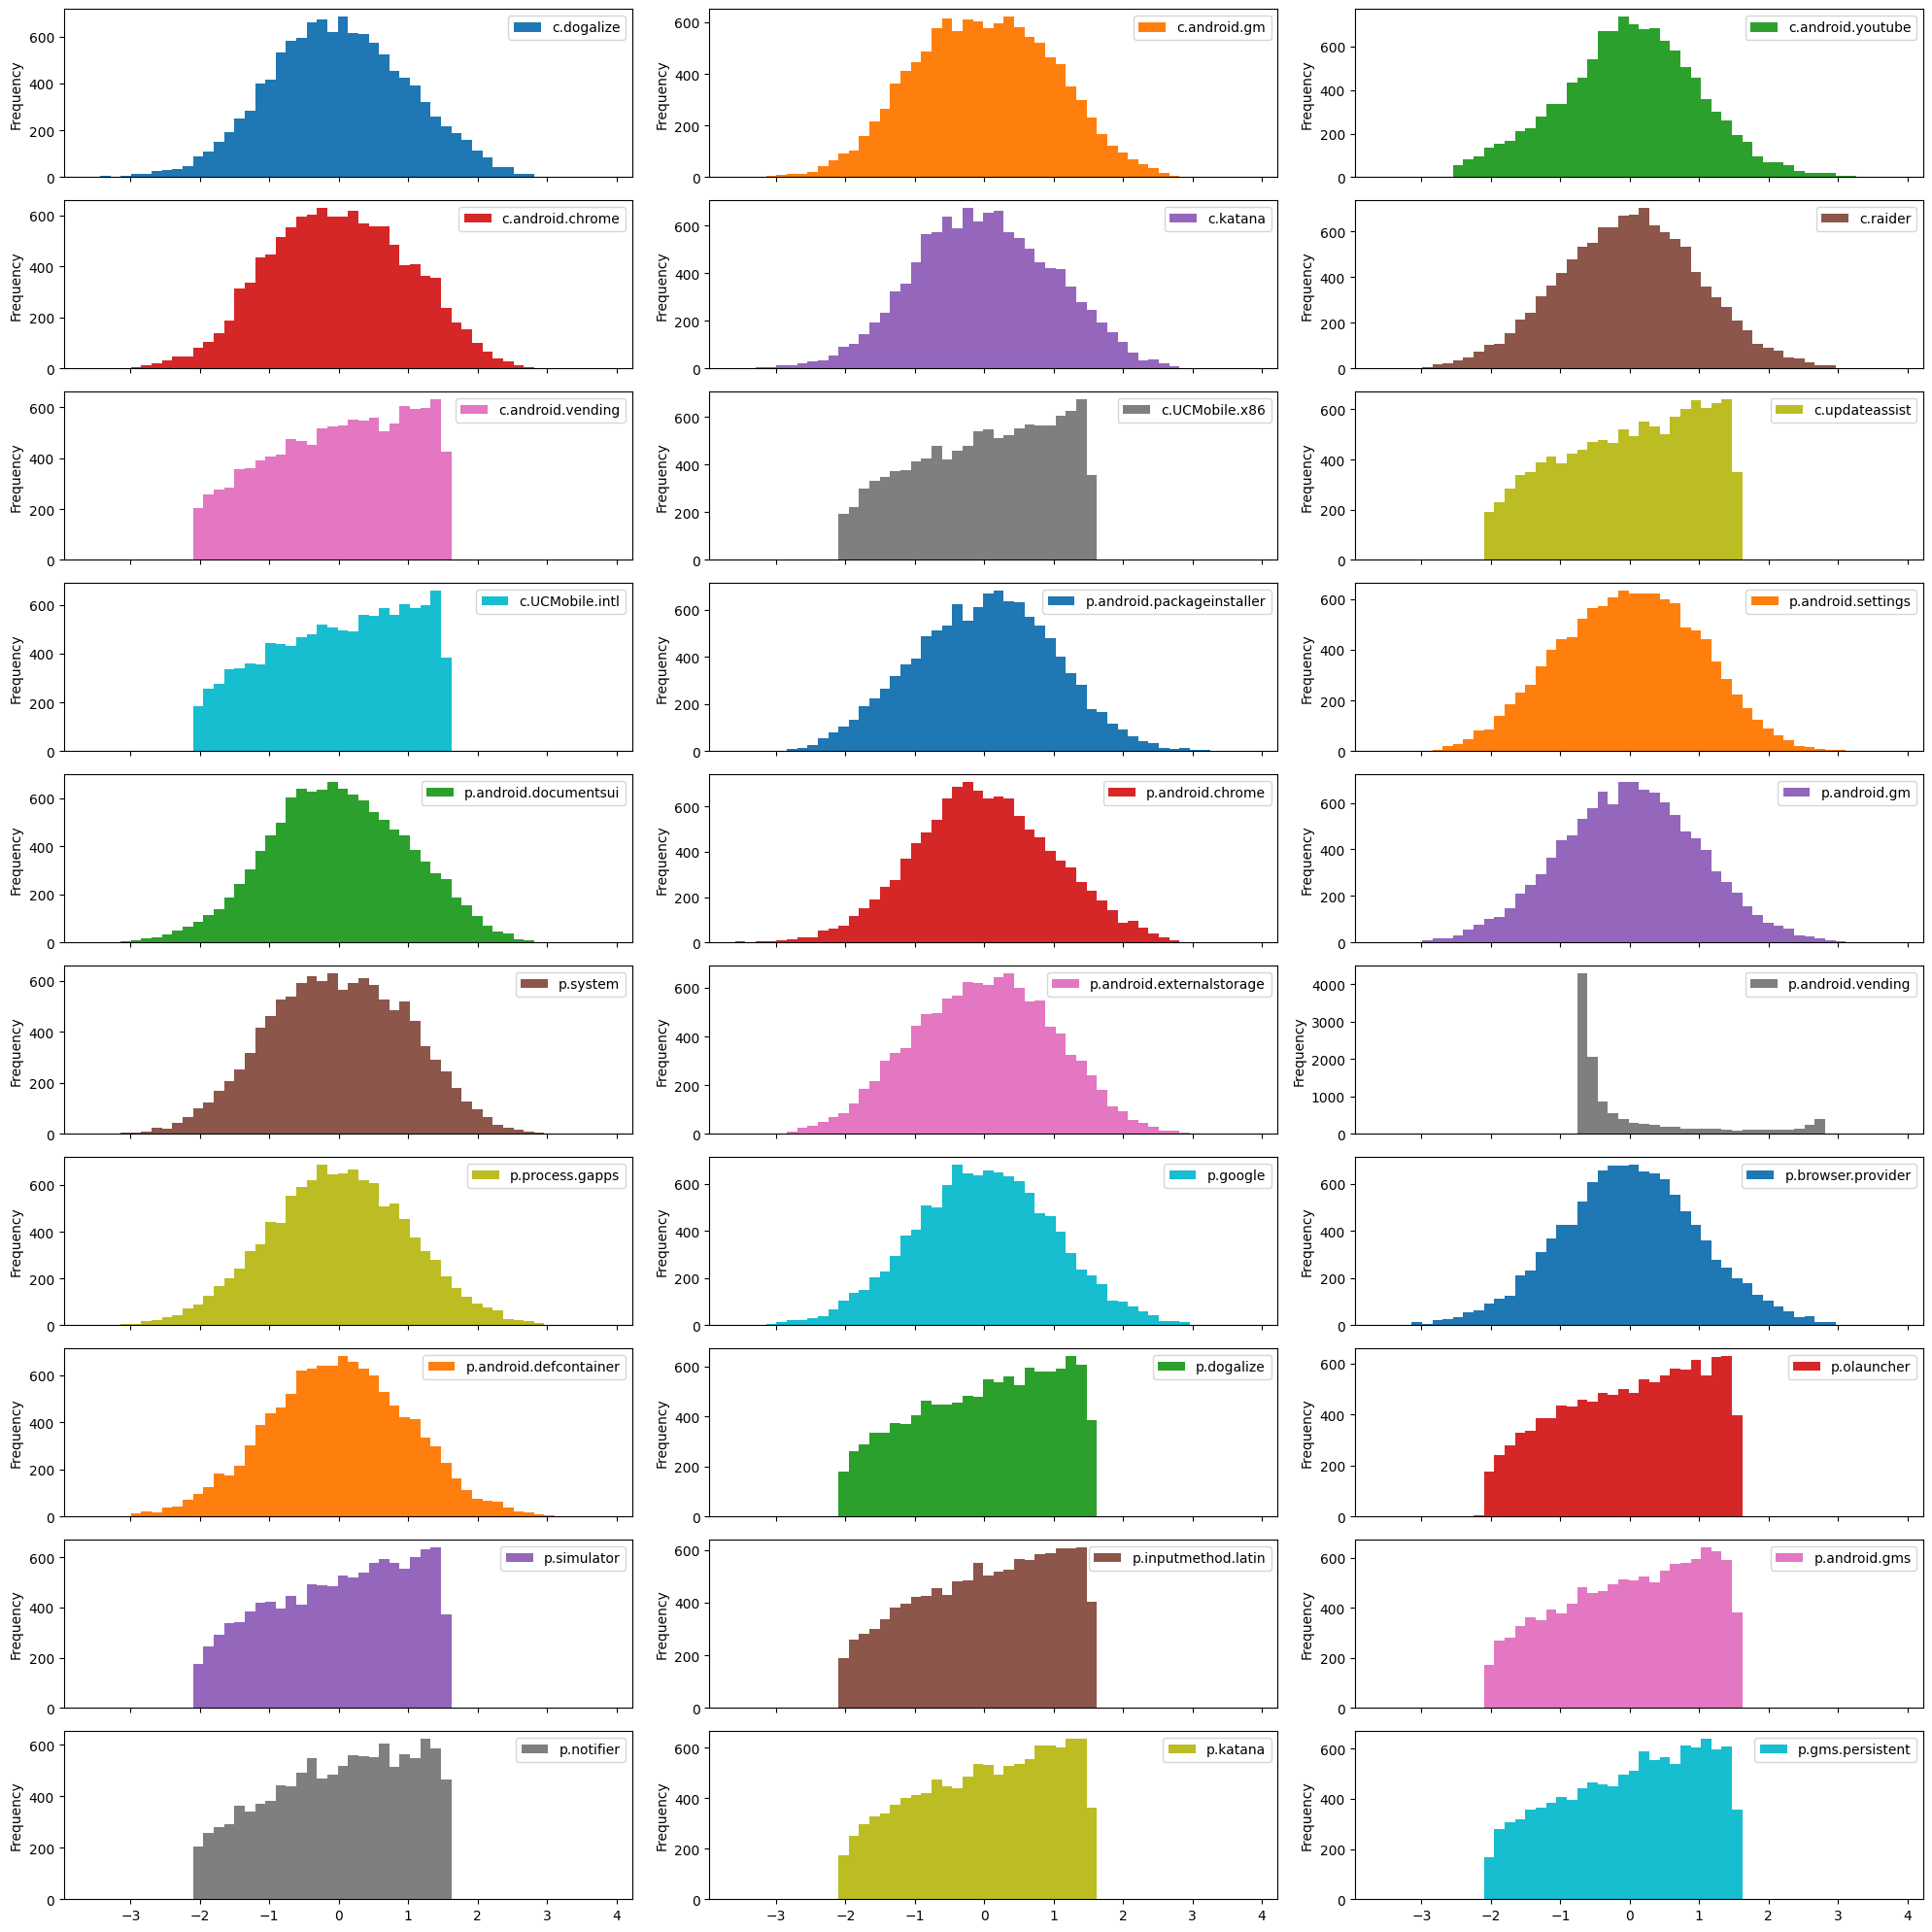

In [21]:
power_transformer = PowerTransformer(method="yeo-johnson")
transformed_data_power = power_transformer.fit_transform(train_data.iloc[:, 3:])

transformed_data_power = pd.DataFrame(transformed_data_power, columns=train_data.columns[3:])
transformed_data_power.plot(kind="hist", bins=50, figsize=(20, 20), subplots=True, layout=(10, 3))
plt.tight_layout()
plt.show()

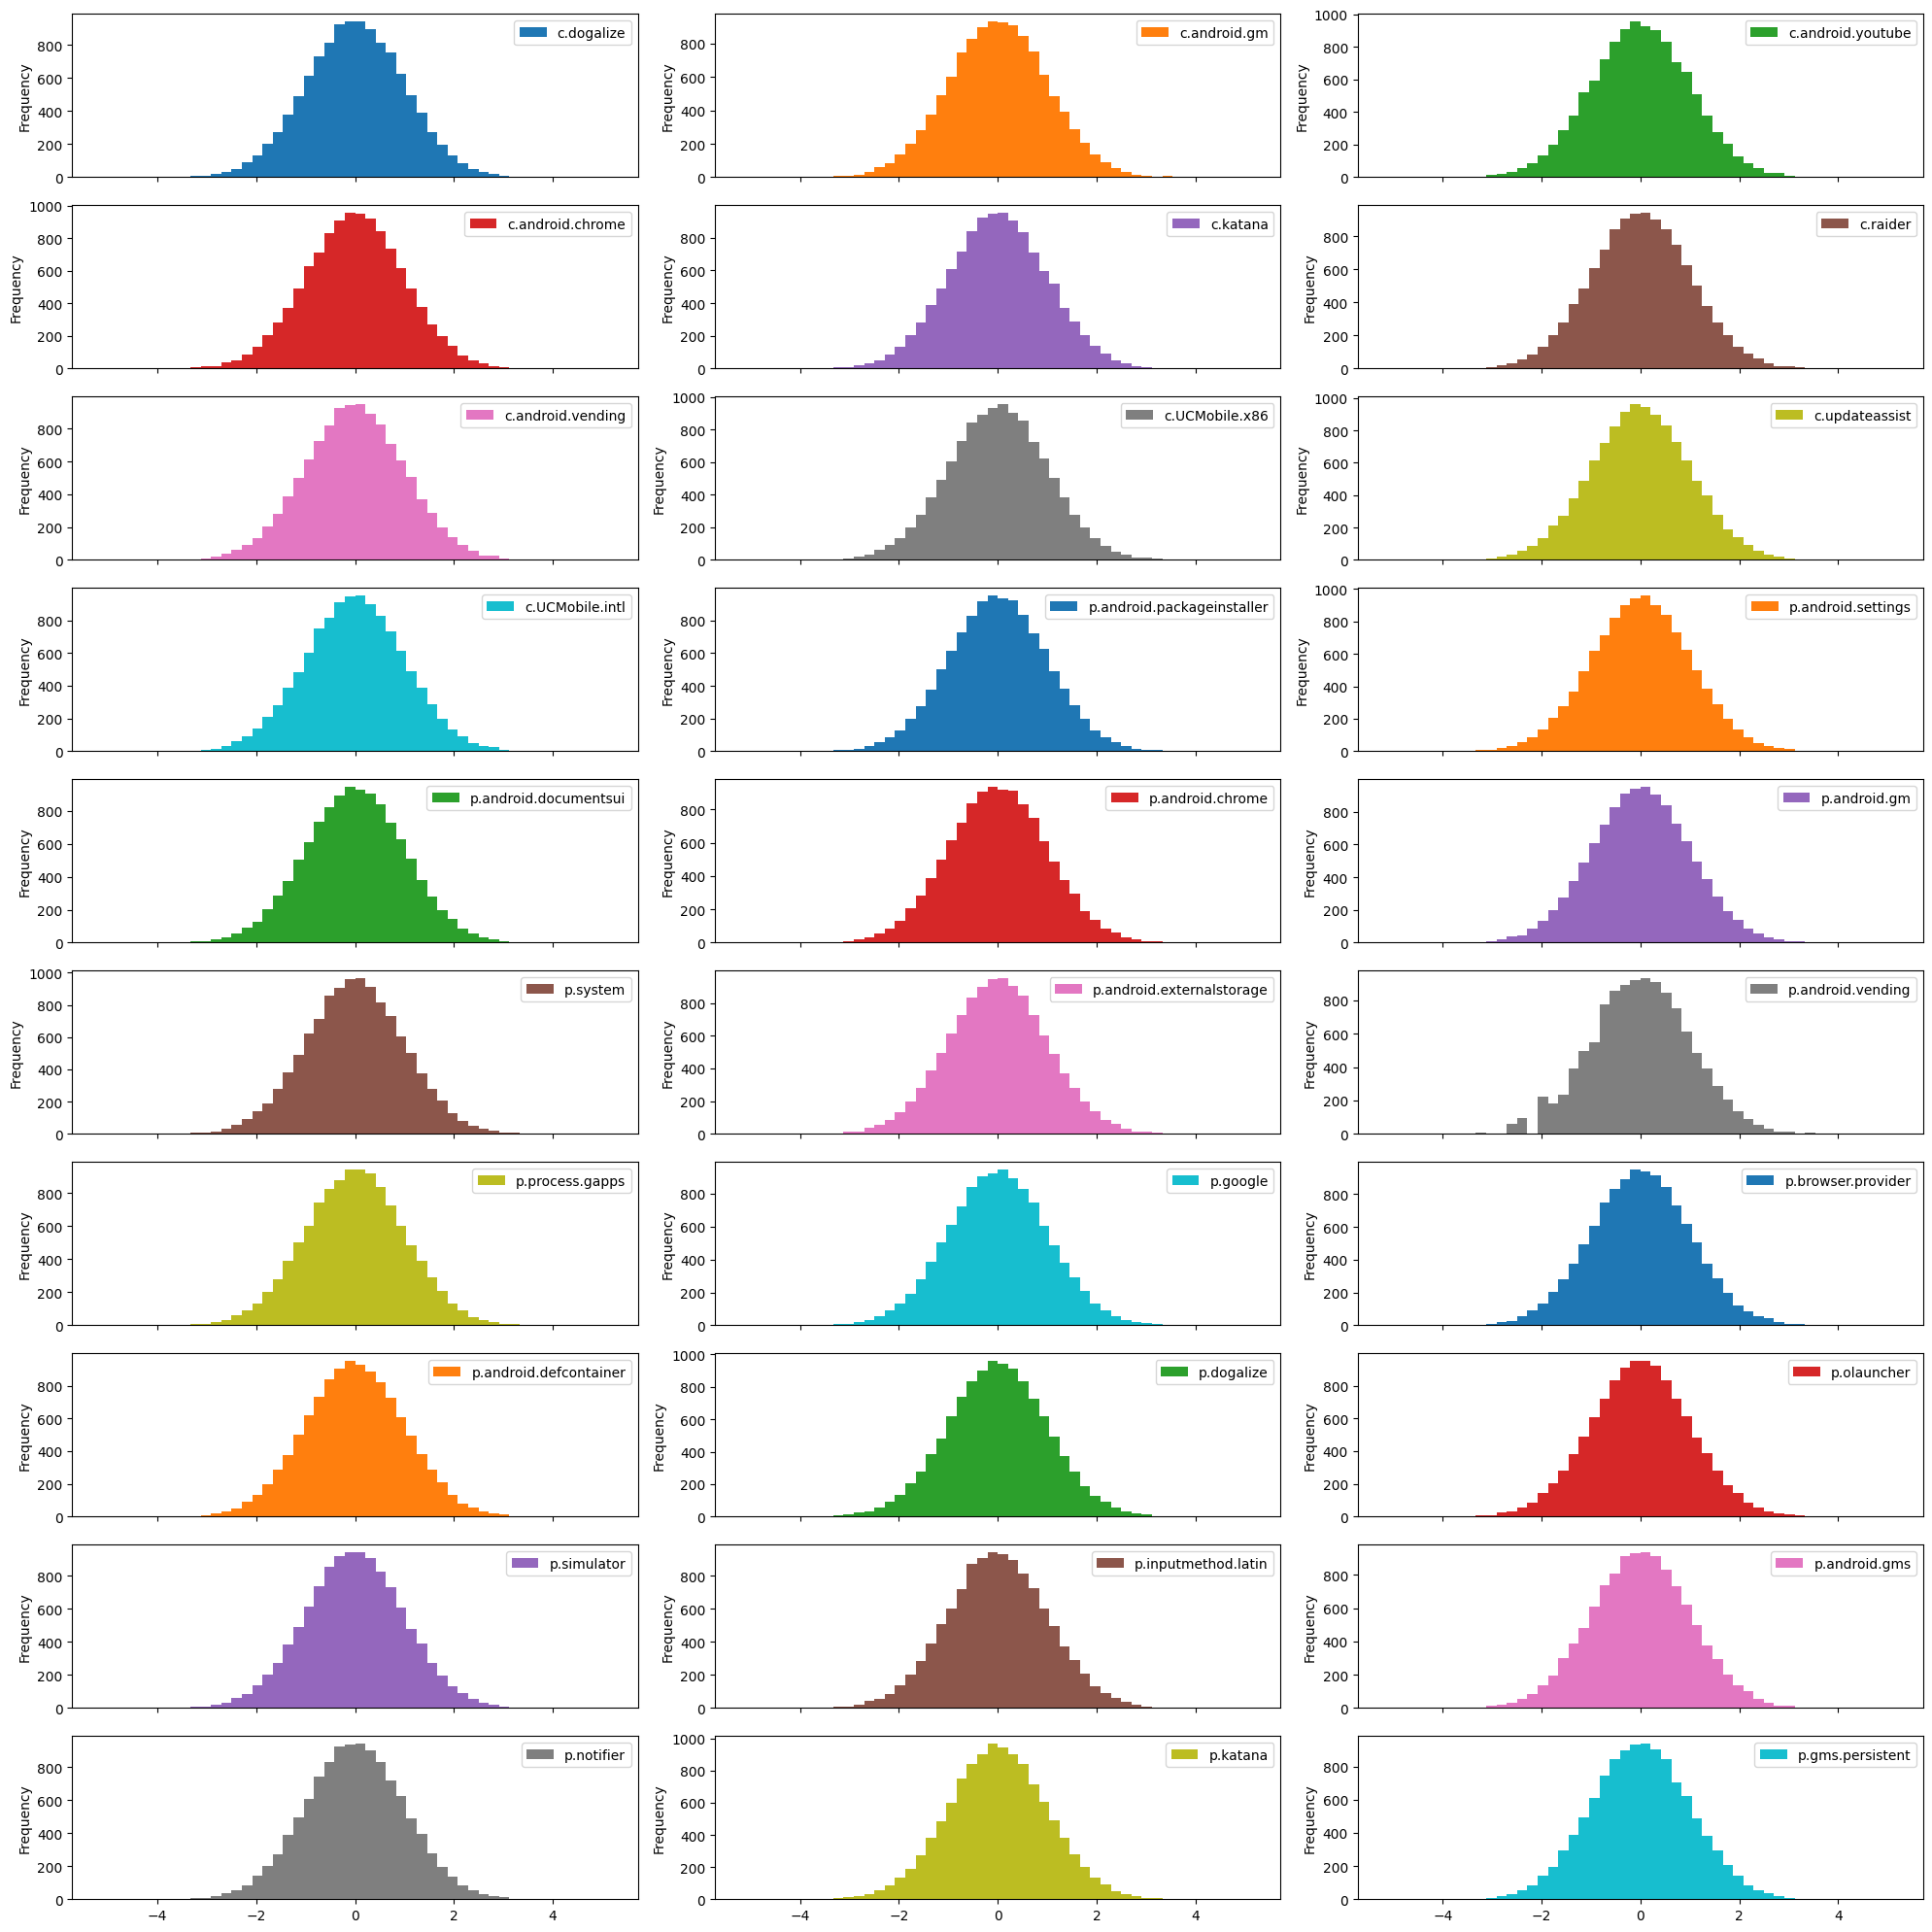

In [22]:
quantile_transformer = QuantileTransformer(output_distribution="normal", random_state=42)
transformed_data = quantile_transformer.fit_transform(train_data.iloc[:, 3:])

transformed_data = pd.DataFrame(transformed_data, columns=train_data.columns[3:])
transformed_data.plot(kind="hist", bins=50, figsize=(20, 20), subplots=True, layout=(10, 3))
plt.tight_layout()
plt.show()

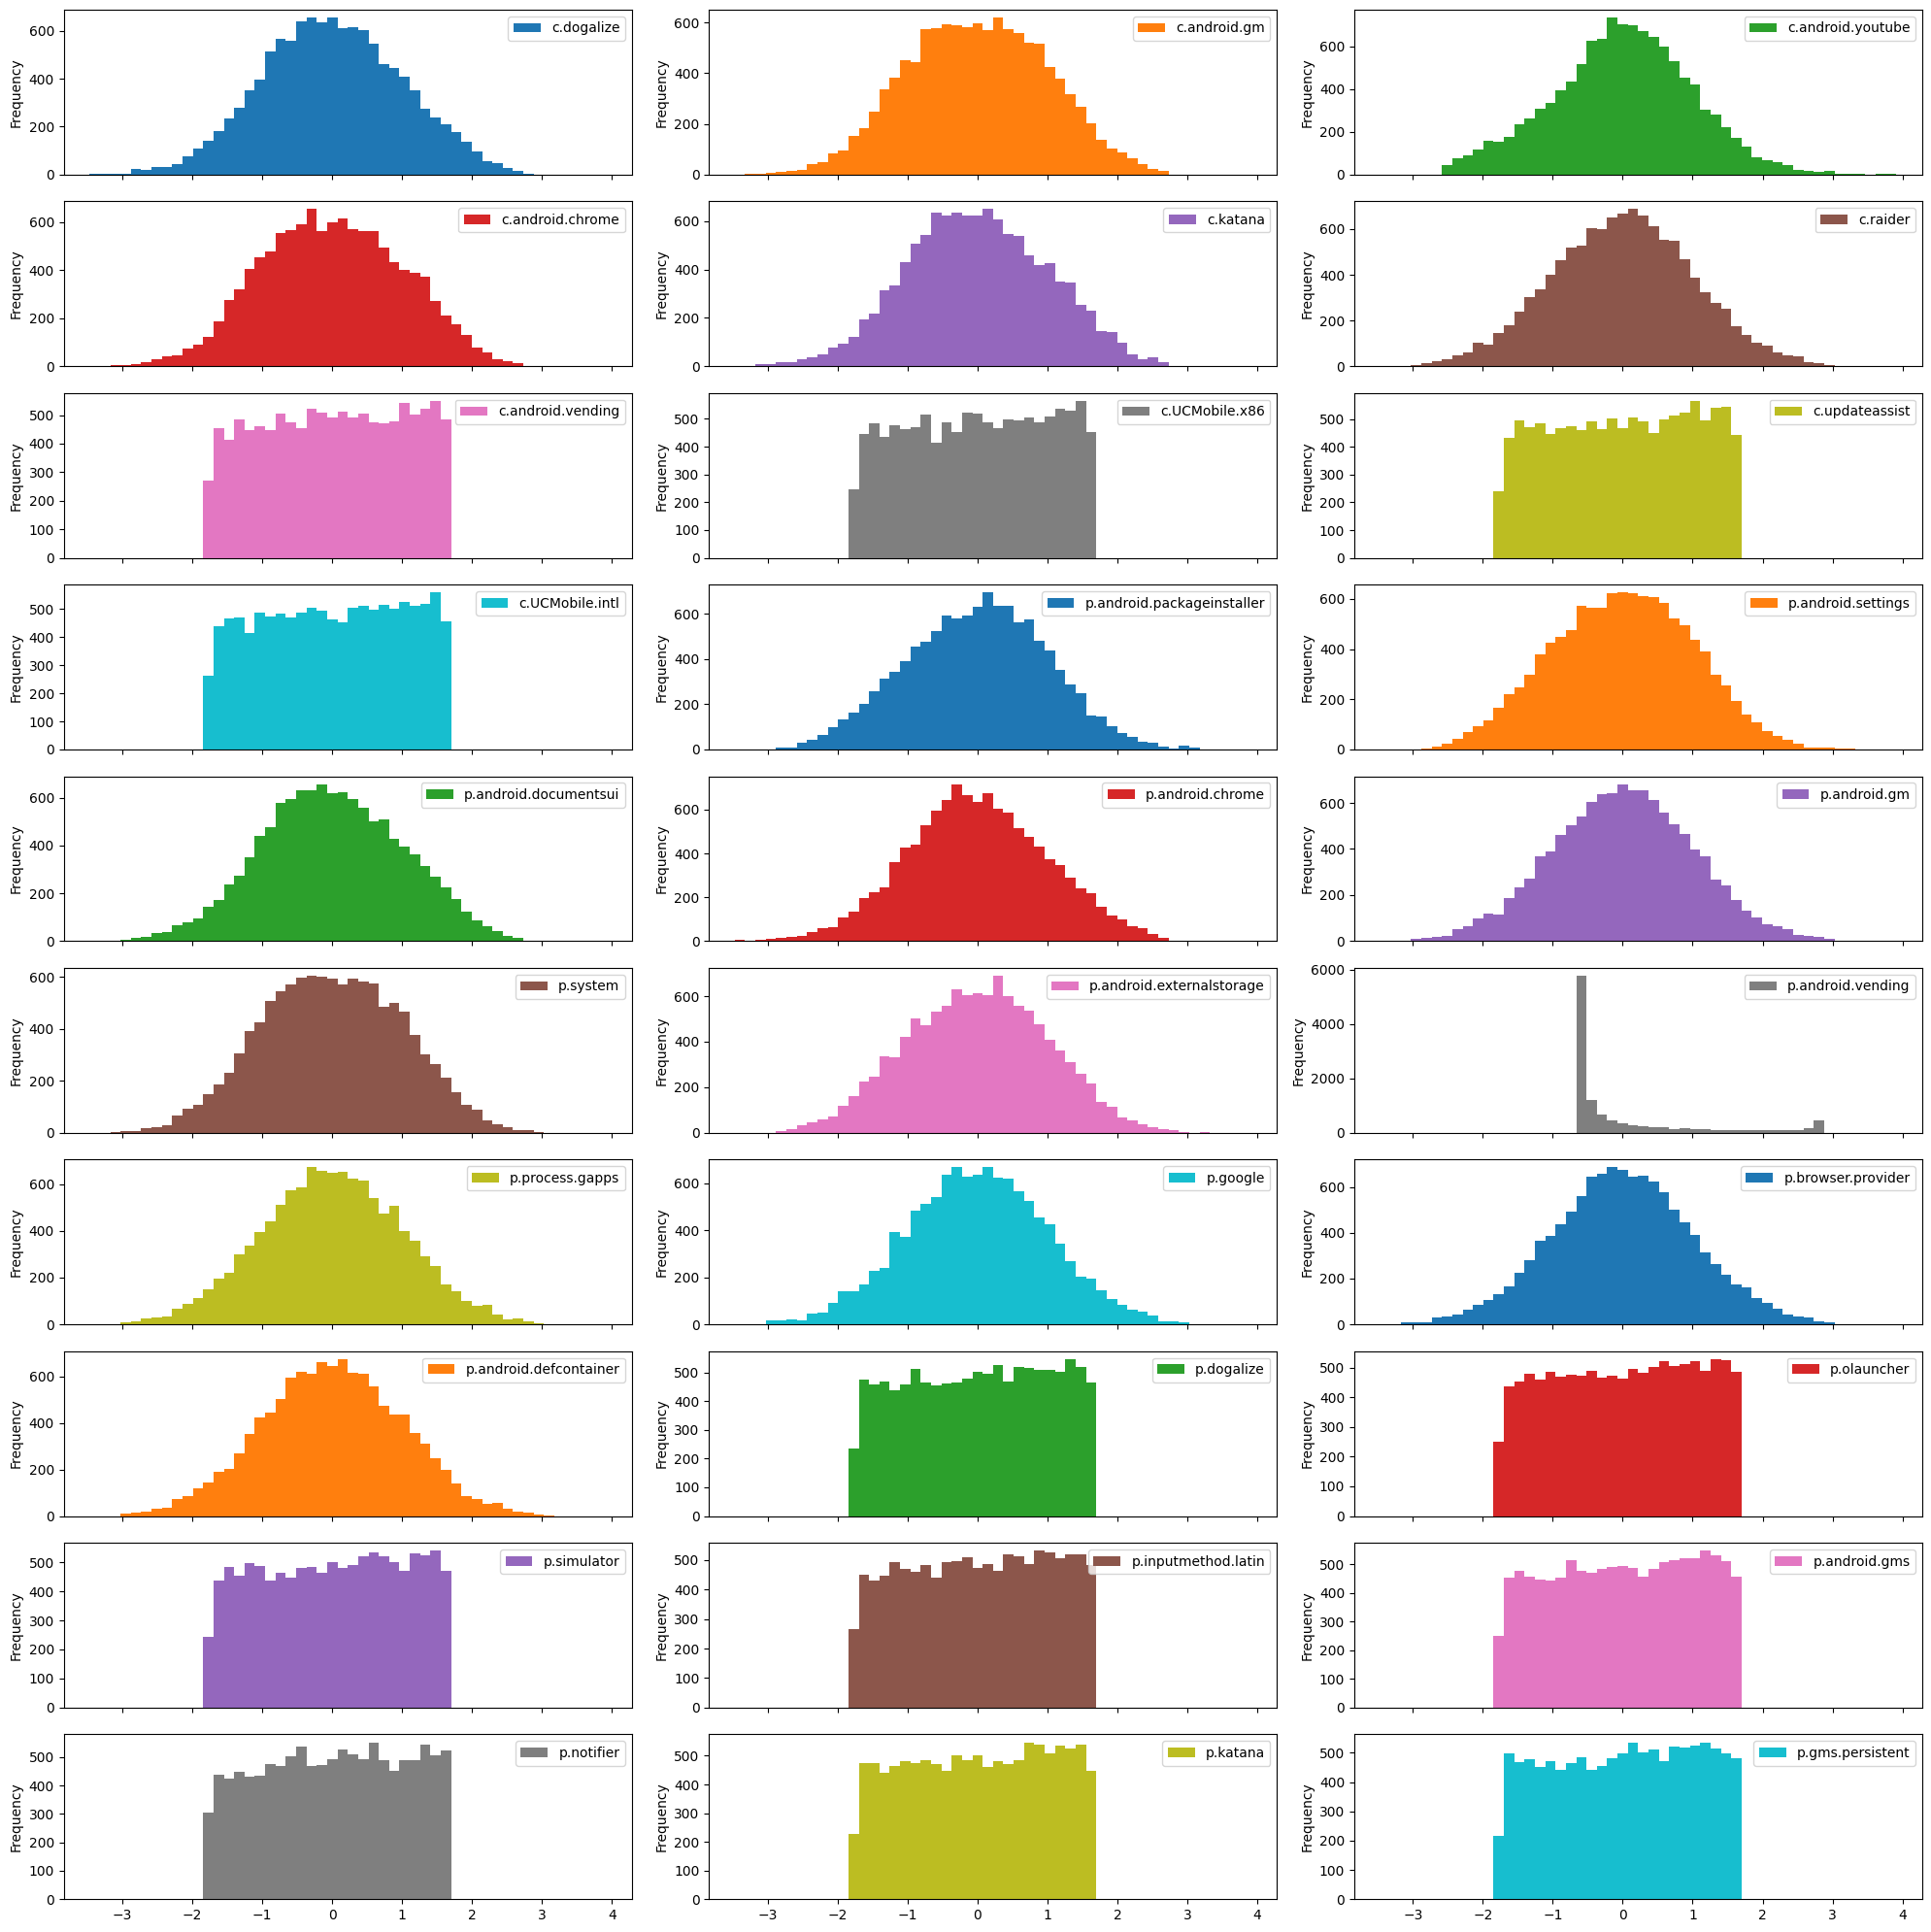

In [23]:
power_transformer = PowerTransformer(method="yeo-johnson")
transformed_data_power = power_transformer.fit_transform(scaled_data_minmax)

transformed_data_power = pd.DataFrame(transformed_data_power, columns=train_data.columns[3:])
transformed_data_power.plot(kind="hist", bins=50, figsize=(20, 20), subplots=True, layout=(10, 3))
plt.tight_layout()
plt.show()

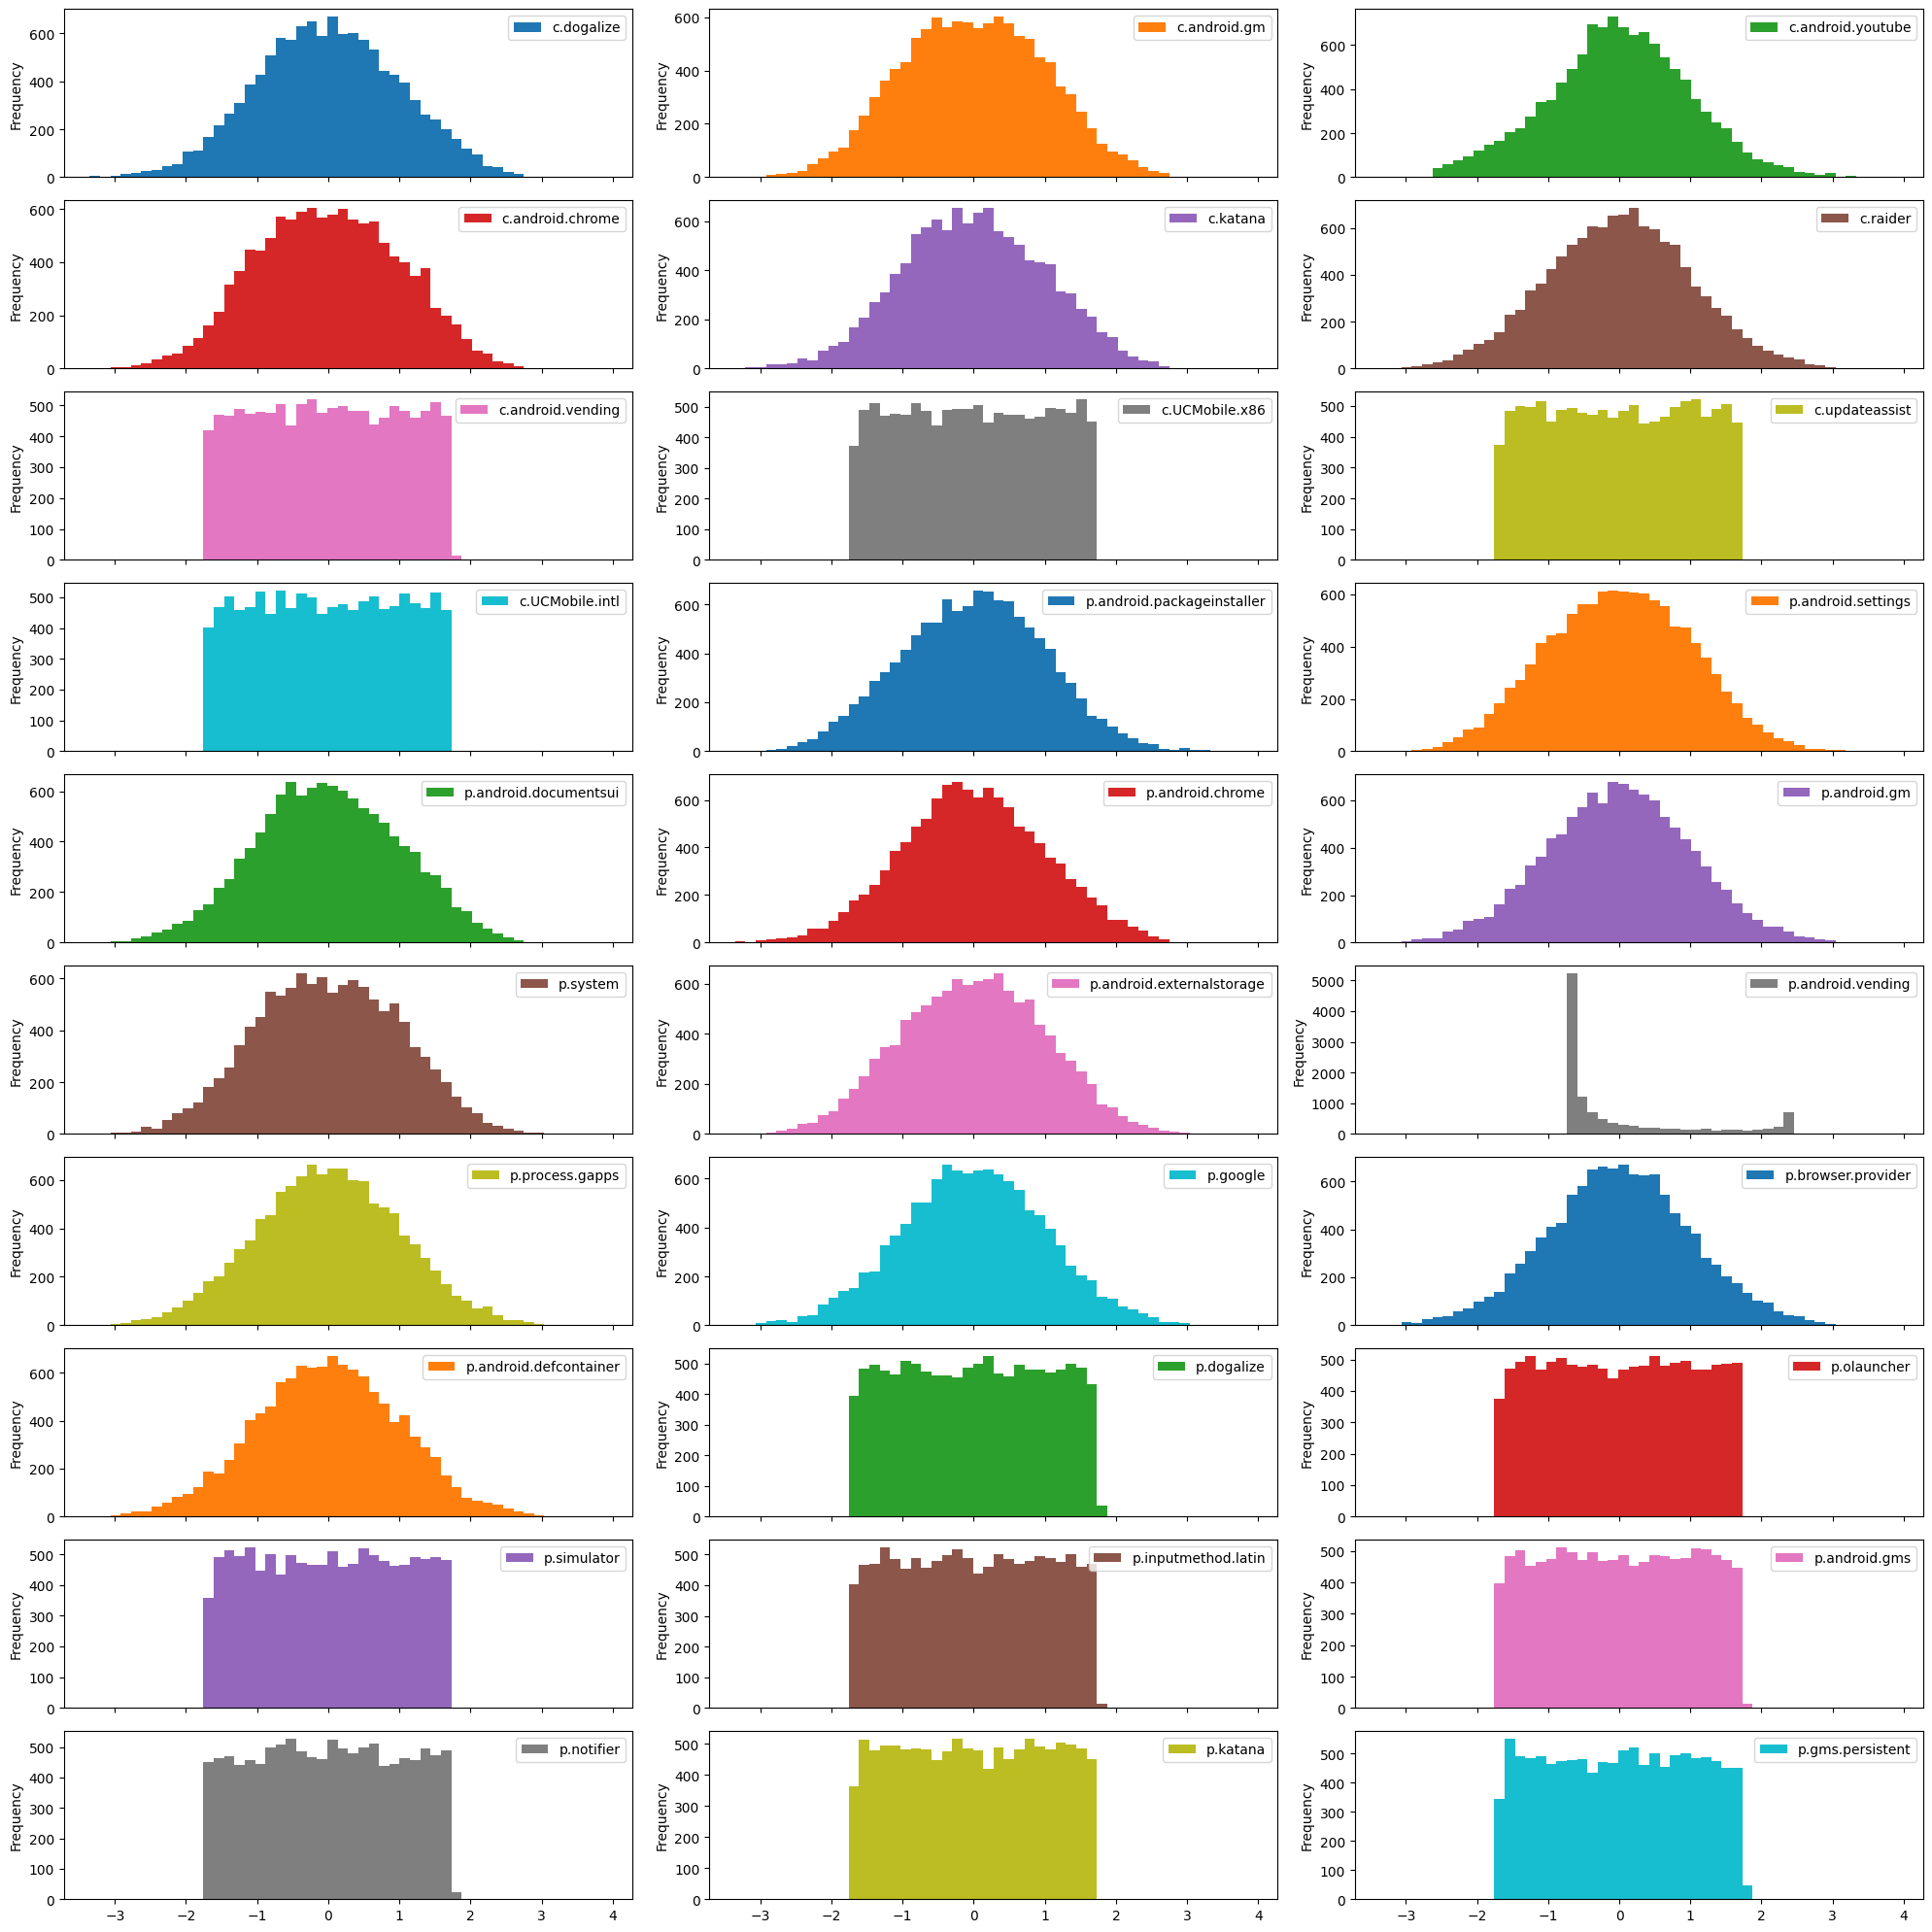

In [24]:
power_transformer = PowerTransformer(method="yeo-johnson")
transformed_data_power = power_transformer.fit_transform(scaled_data_standard)

transformed_data_power = pd.DataFrame(transformed_data_power, columns=train_data.columns[3:])
transformed_data_power.plot(kind="hist", bins=50, figsize=(20, 20), subplots=True, layout=(10, 3))
plt.tight_layout()
plt.show()

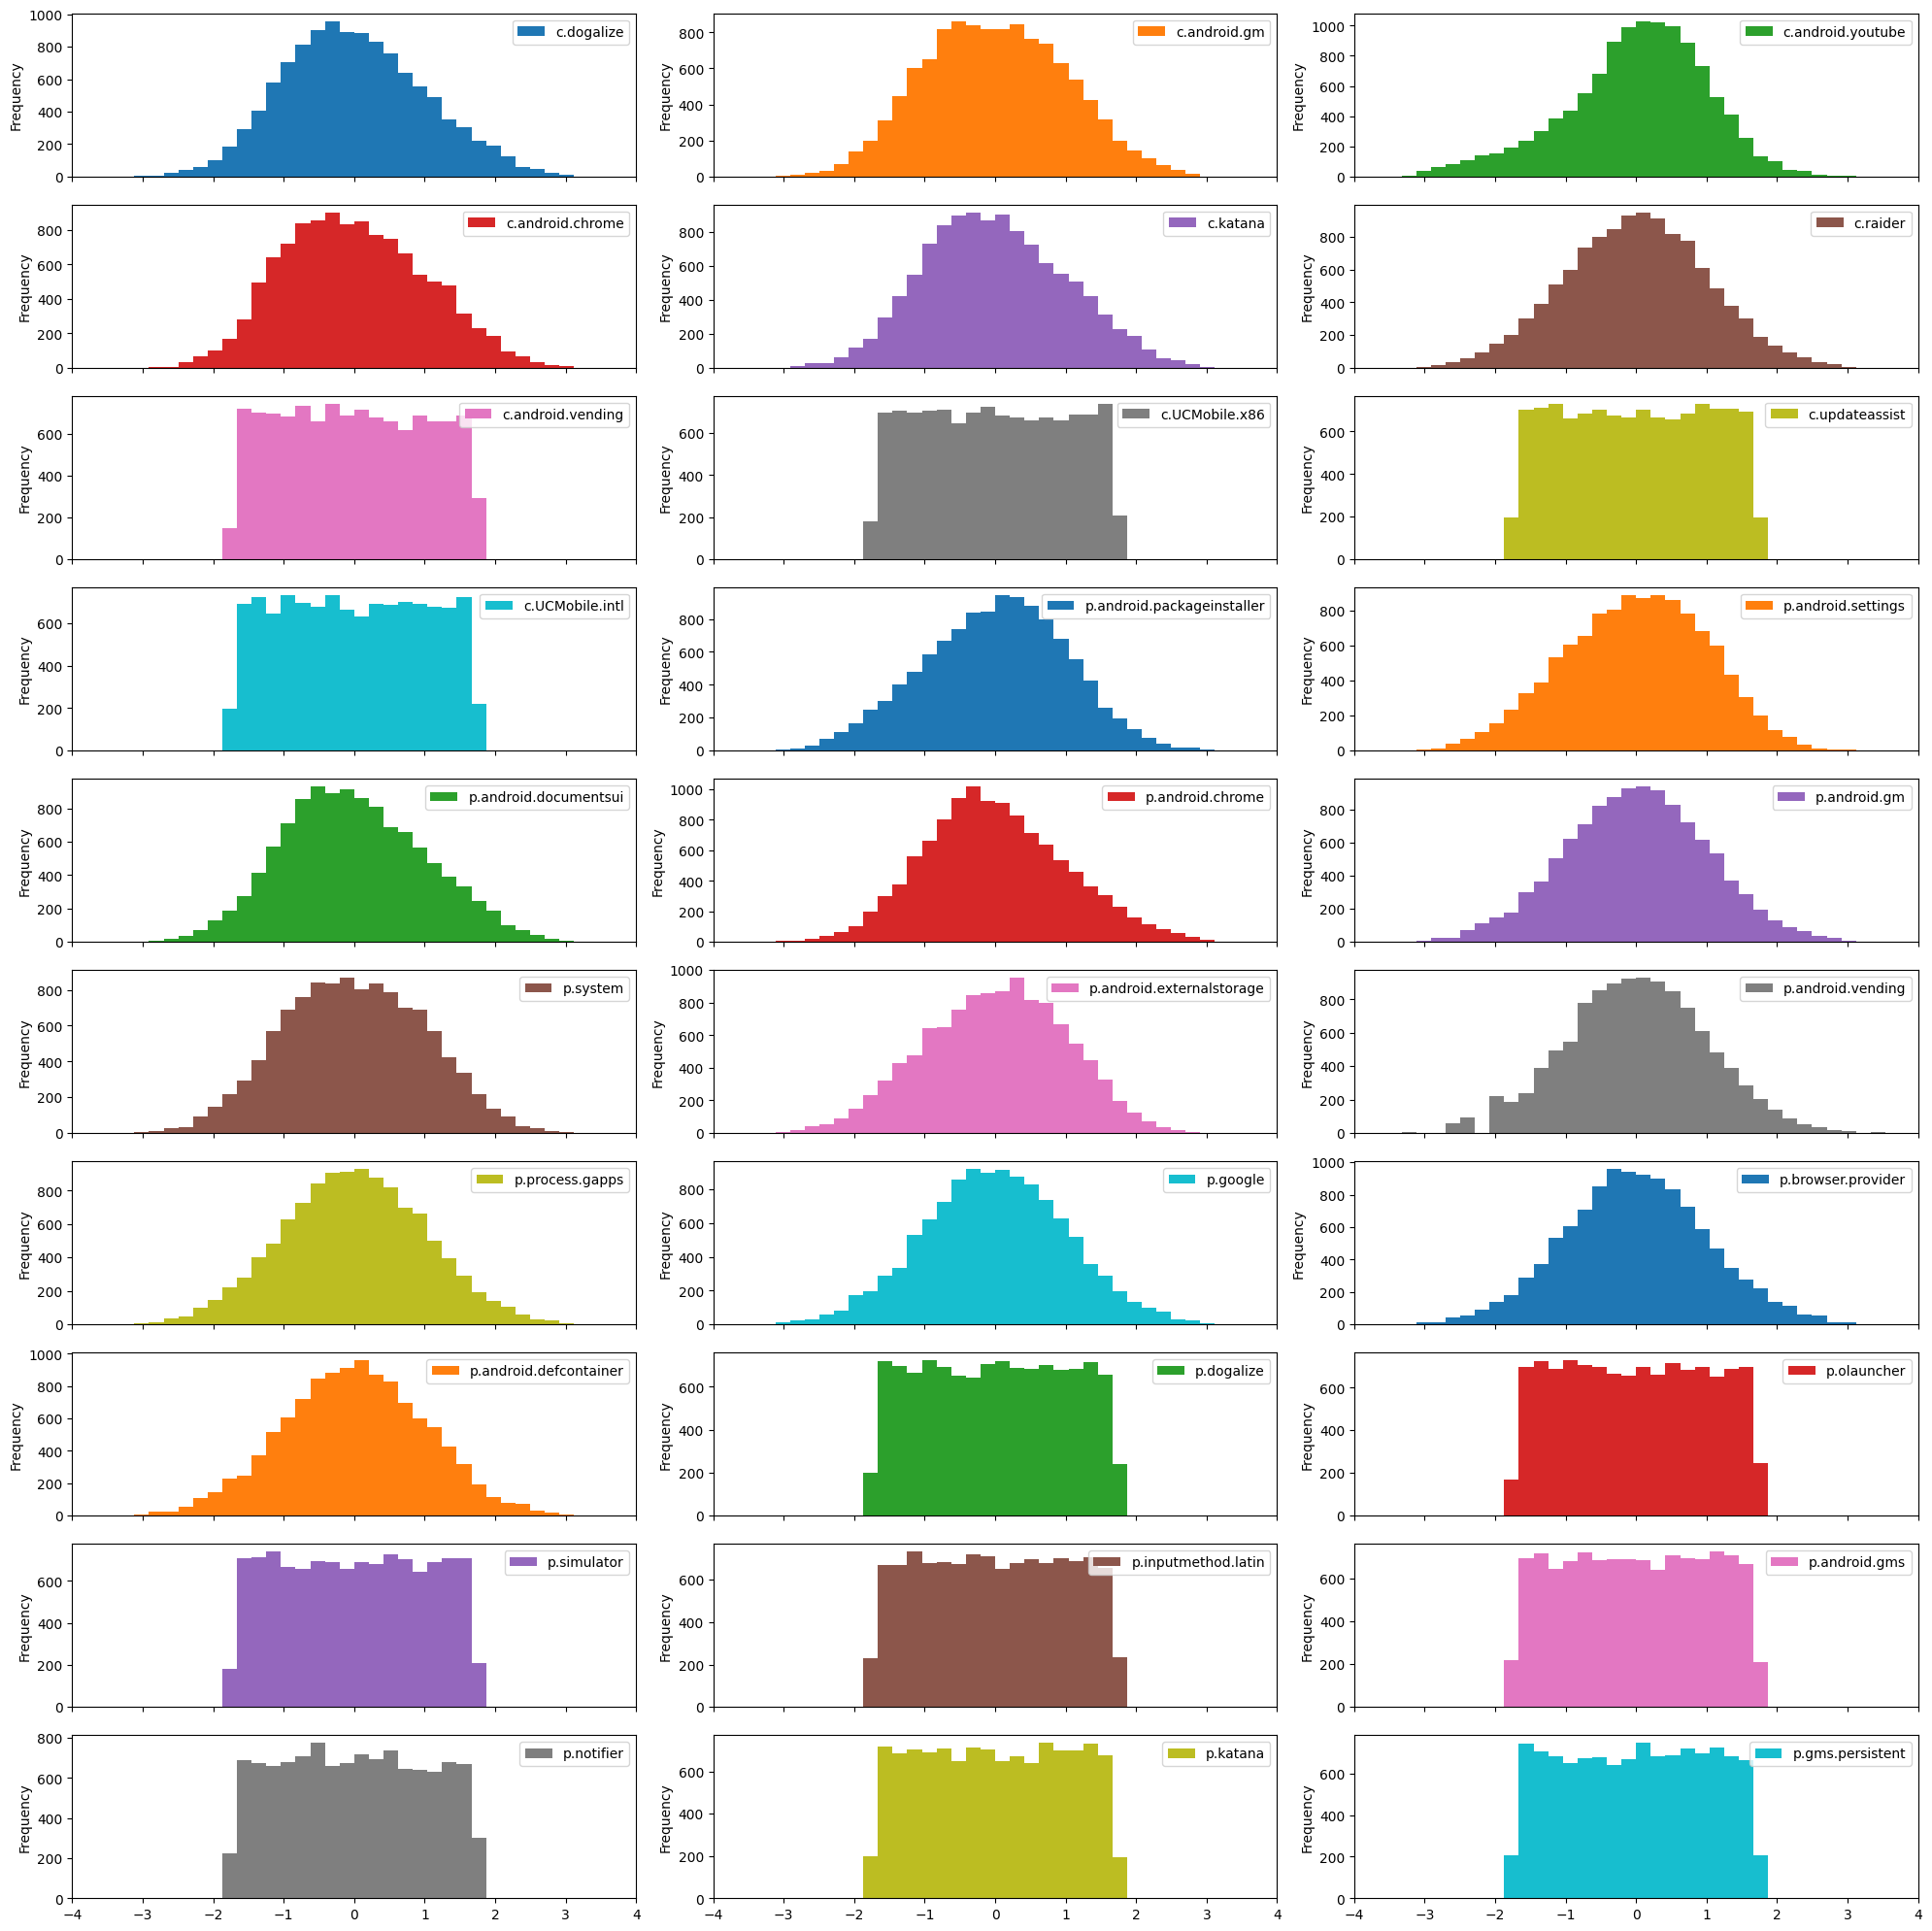

In [25]:
scaler = StandardScaler()
scaled_data_minmax = scaler.fit_transform(train_data.iloc[:, 3:])

scaled_data_minmax = pd.DataFrame(scaled_data_minmax, columns=train_data.columns[3:])
quantile_transformer = QuantileTransformer(output_distribution="normal", random_state=42)
scaled_data_minmax["p.android.vending"] = quantile_transformer.fit_transform(
    scaled_data_minmax[["p.android.vending"]]
)
scaled_data_minmax = pd.DataFrame(scaled_data_minmax, columns=train_data.columns[3:])

scaled_data_minmax.plot(kind="hist", bins=50, figsize=(20, 20), subplots=True, layout=(10, 3))
plt.xlim(-4, 4)
plt.tight_layout()
plt.show()

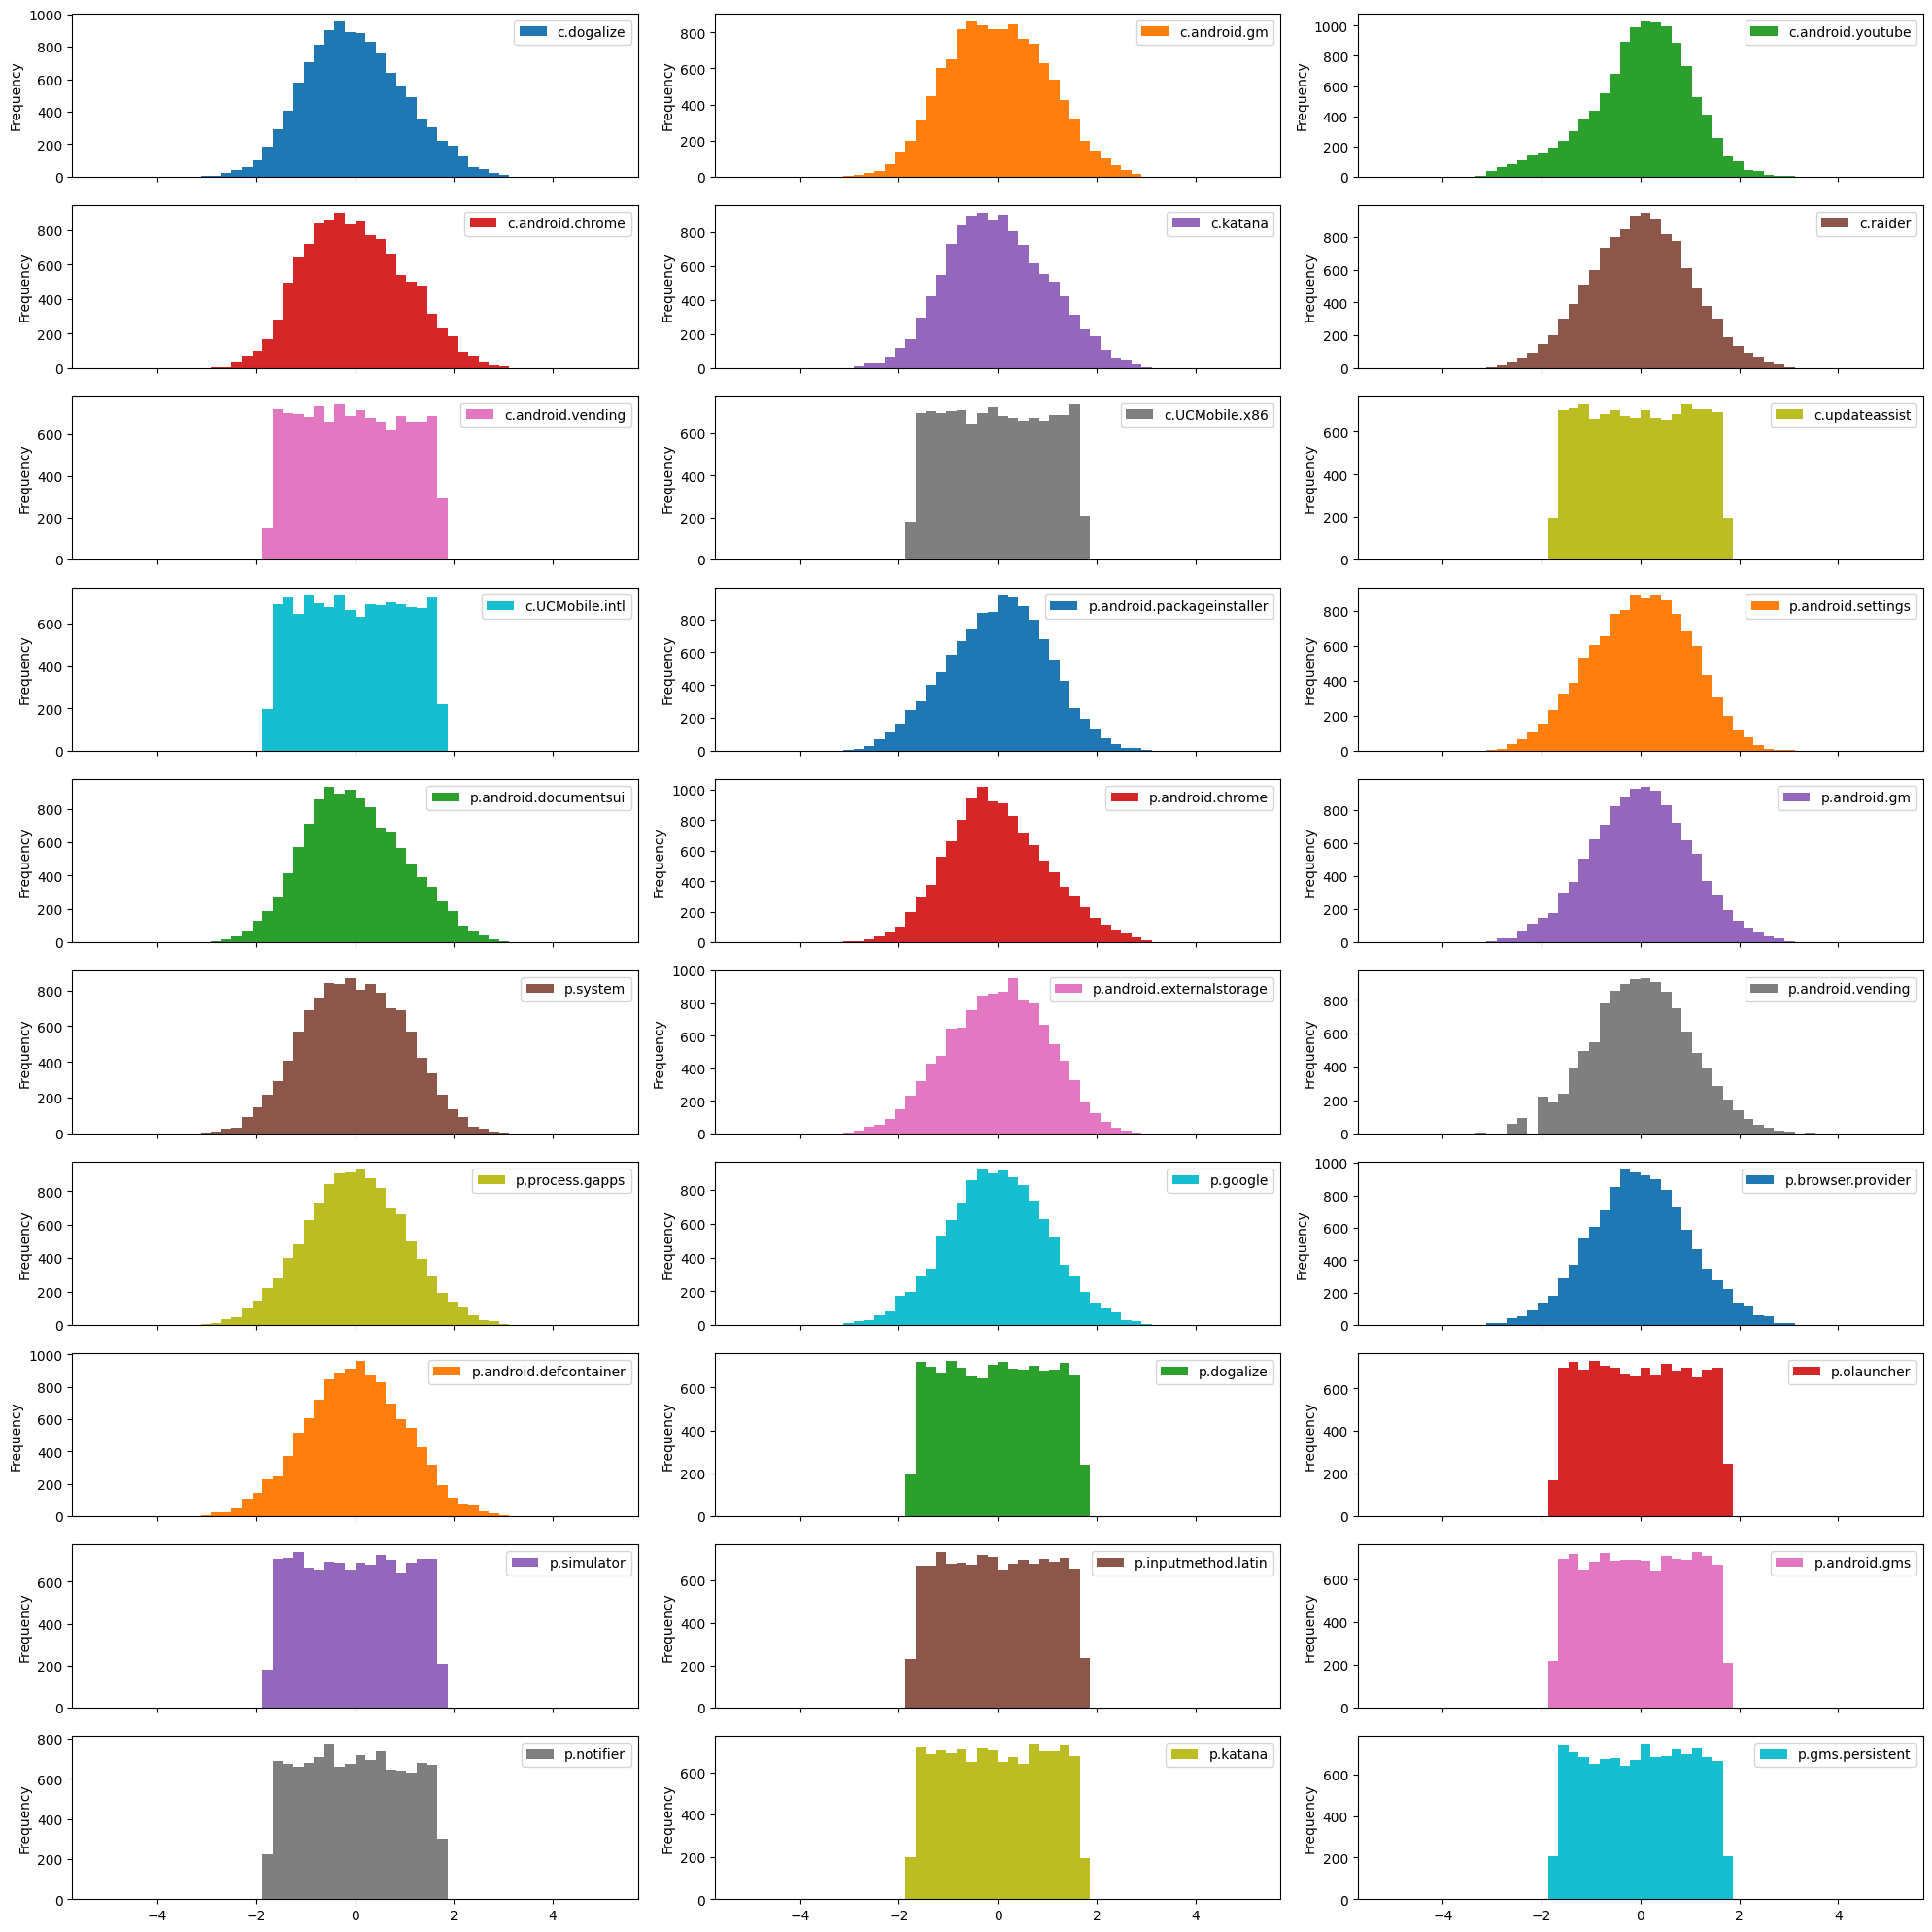

In [26]:
scaler = StandardScaler()
scaled_data_minmax = scaler.fit_transform(train_data.iloc[:, 3:])

scaled_data_minmax = pd.DataFrame(scaled_data_minmax, columns=train_data.columns[3:])
quantile_transformer = QuantileTransformer(output_distribution="normal", random_state=42)
scaled_data_minmax["p.android.vending"] = quantile_transformer.fit_transform(
    scaled_data_minmax[["p.android.vending"]]
)
scaled_data_minmax = pd.DataFrame(scaled_data_minmax, columns=train_data.columns[3:])

scaled_data_minmax.plot(kind="hist", bins=50, figsize=(20, 20), subplots=True, layout=(10, 3))
plt.tight_layout()
plt.show()

## D

### **Zadanie:** Zdôvodnite Vaše voľby/rozhodnutie pre realizáciu (t.j. zdokumentovanie)


In previous sections we have gathered these insights:

-   Scaling:
    -   We identified need for scaling data, because data has different ranges
    -   Min-Max Scaling showed promising results, when not combining with anything else
    -   Standard Scaler showed also promising results, the only problem was column **'p.android.vending'** as it has too big range and many outliers (we used Z-score(3), maybe using quantile detection could improved this), the scaled graph also showed outliers
-   Transformers:
    -   Power Transformer didn't show that promising results for uniform graphs (it made the a little logarithmic), but promising results for normal graphs
    -   Quantile Transformer transforms data to perfect normal distribution, but it could distort linear correlations
-   Combinations:
    -   Using Min-Max Scaler and Power Transformer showed promising results, as it transform data to normal distributions and also kept uniform distributions (didn't make them logarithmic, but there is some very slight logarithmic effect)
    -   Using Standard Scaler and Power Transformer showed even more promising results compared to Using Min-Max Scaler and Power Transformer, as it transform data to normal distributions and also kept uniform distributions without any logarithmic effect
-   Final choice:
    -   We are going to use Standard Scaler and Power Transformer, and after this we apply Quantile Transformer for **'p.android.vending'**


# 2.2


## A

### **Zadanie:** Zistite, ktoré atribúty (features) vo vašich dátach pre ML sú informatívne k predikovanej premennej (minimálne 3 techniky s porovnaním medzi sebou).


### Variance Threshold


In [27]:
selector = VarianceThreshold(threshold=(0.8 * (1 - 0.8)))
selector.fit(train_data.iloc[:, 3:])
support_mask = selector.get_support()

removed_columns = train_data.iloc[:, 3:].columns[~support_mask].tolist()

print("Removed columns:", removed_columns)

Removed columns: ['p.android.vending']


-   We see thins method would remove **'p.android.vending'** feature, which is the most problematic feature that we have in our dataset


In [28]:
variance_threshold_data = train_data.iloc[:, 3:]

thresholds = np.arange(0.0, 1, 0.05)
results = list()
for t in thresholds:
    transform = VarianceThreshold(threshold=t)
    tmp = transform.fit_transform(variance_threshold_data)
    n_features = tmp.shape[1]
    print(">Threshold=%.2f, Features=%d" % (t, n_features))
    results.append(n_features)

>Threshold=0.00, Features=30
>Threshold=0.05, Features=29
>Threshold=0.10, Features=29
>Threshold=0.15, Features=29
>Threshold=0.20, Features=29
>Threshold=0.25, Features=29
>Threshold=0.30, Features=29
>Threshold=0.35, Features=29
>Threshold=0.40, Features=29
>Threshold=0.45, Features=29
>Threshold=0.50, Features=29
>Threshold=0.55, Features=29
>Threshold=0.60, Features=29
>Threshold=0.65, Features=29
>Threshold=0.70, Features=29
>Threshold=0.75, Features=29
>Threshold=0.80, Features=29
>Threshold=0.85, Features=29
>Threshold=0.90, Features=29
>Threshold=0.95, Features=29


-   We see different threshold values have no effect on the results


### Mutual Information


In [29]:
X = train_data.drop(columns=["mwra", "ts", "imei"])
y = train_data["mwra"]

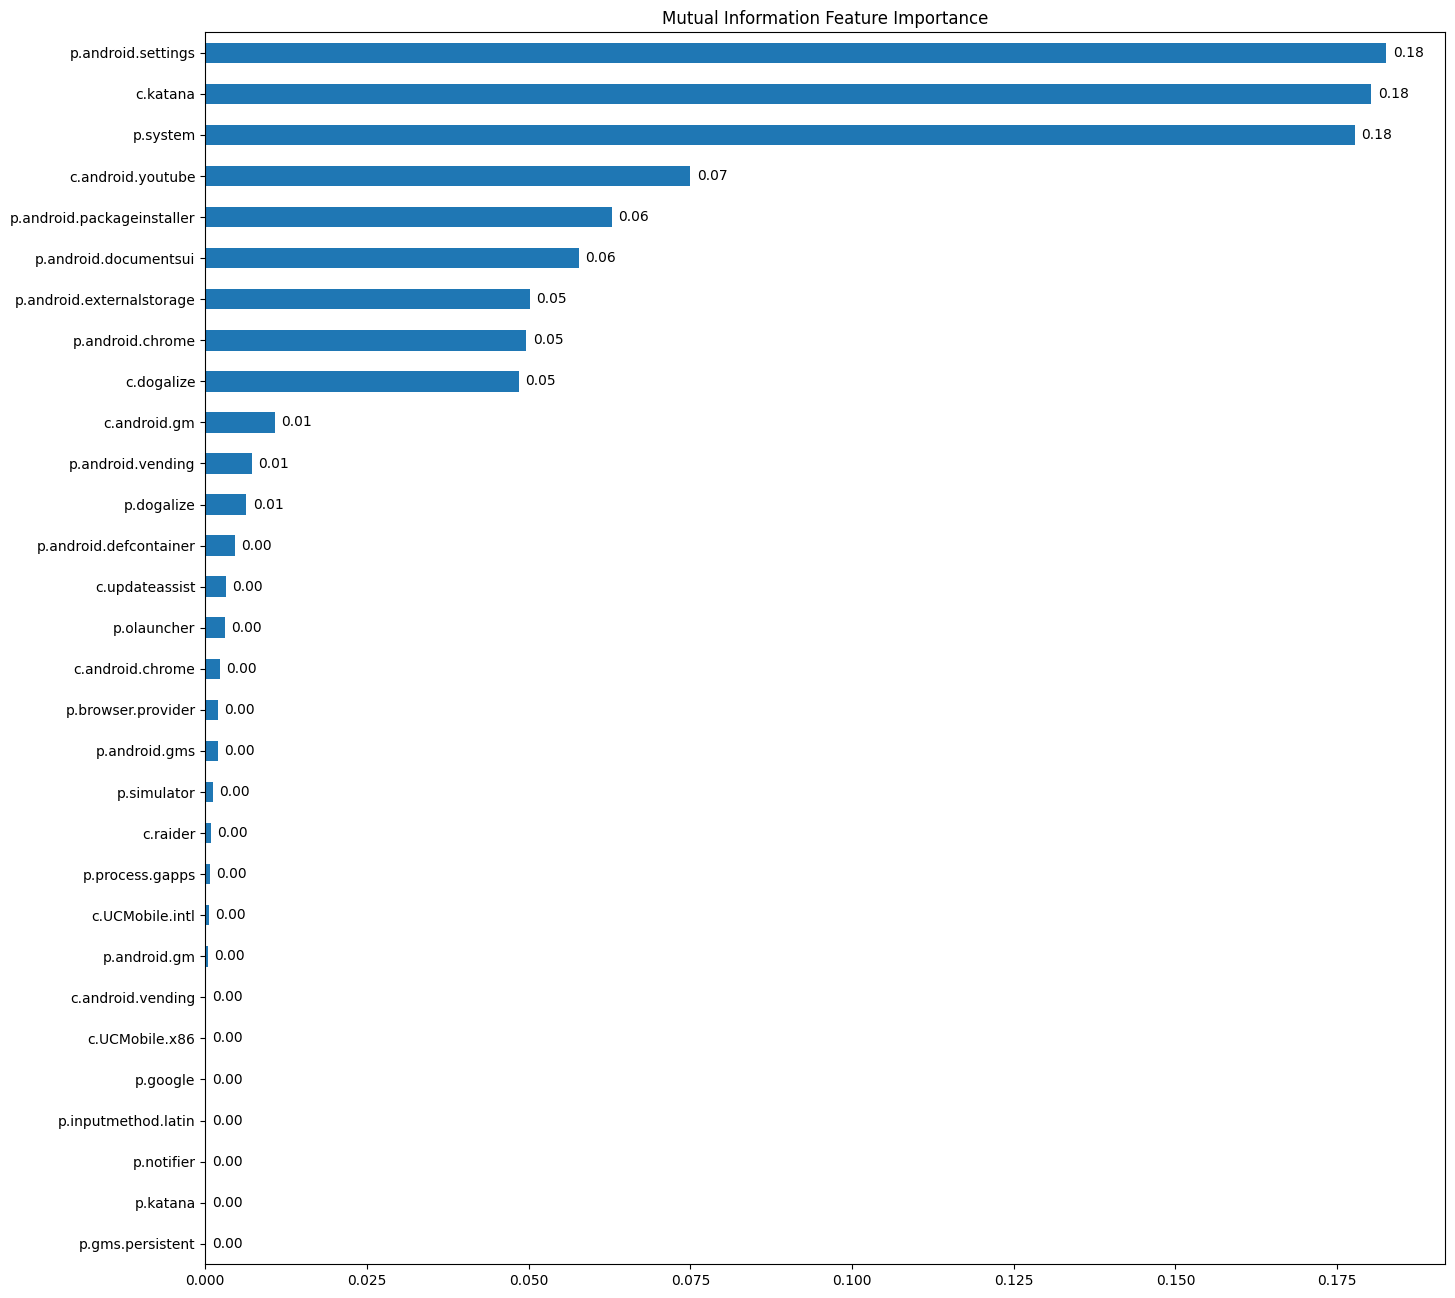

In [30]:
selector = mutual_info_classif(X, y)
importance = pd.Series(selector, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(16, 16))
ax = importance.plot(kind="barh")

for i, v in enumerate(importance):
    ax.text(v + 0.001, i, f"{v:.2f}", va="center")

plt.gca().invert_yaxis()
plt.title("Mutual Information Feature Importance")
plt.show()

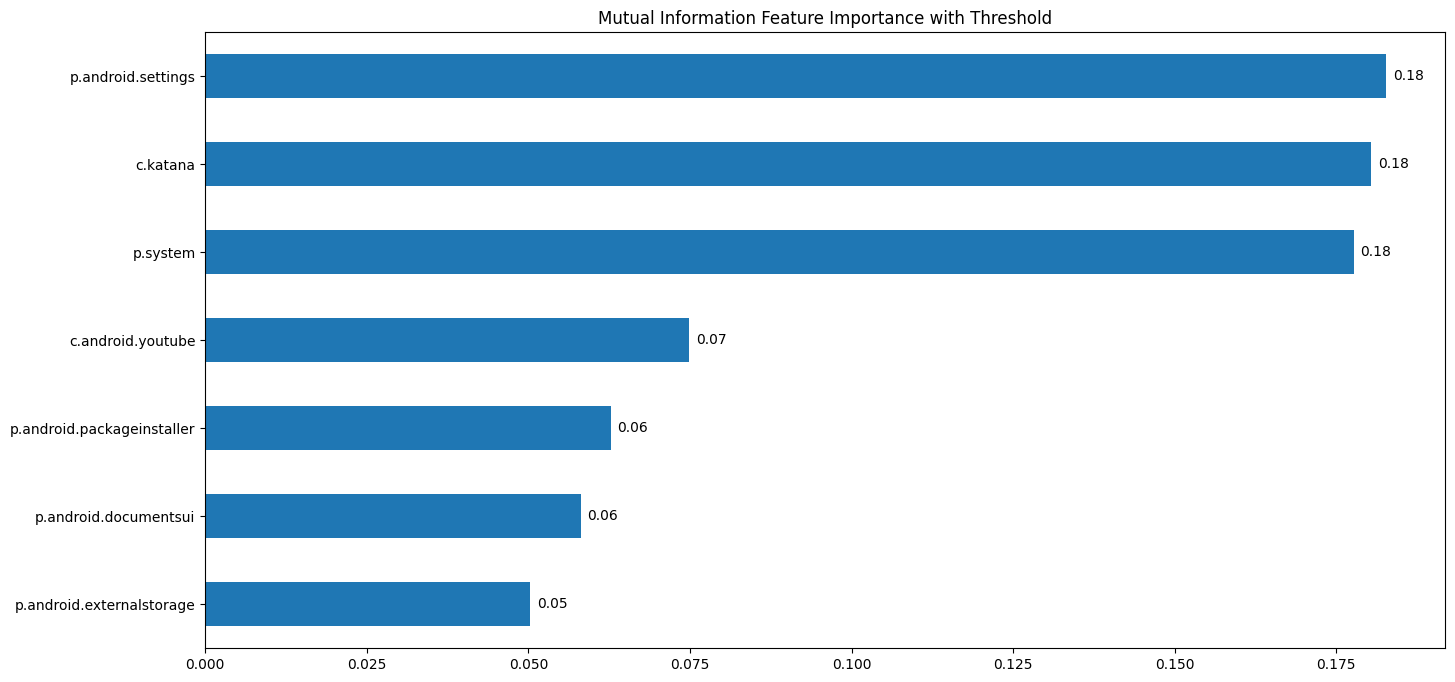

,0
p.android.settings,0.182715
c.katana,0.180427
p.system,0.177719
c.android.youtube,0.074911
p.android.packageinstaller,0.062804
p.android.documentsui,0.058109
p.android.externalstorage,0.050308


In [31]:
selector = mutual_info_classif(X, y)
importance = pd.Series(selector, index=X.columns).sort_values(ascending=False)
importance = importance[importance > 0.05]

plt.figure(figsize=(16, 8))
ax = importance.plot(kind="barh")

for i, v in enumerate(importance):
    ax.text(v + 0.001, i, f"{v:.2f}", va="center")

plt.gca().invert_yaxis()
plt.title("Mutual Information Feature Importance with Threshold")
plt.show()
importance = pd.DataFrame(importance)
importance

-   We got these features as best:
    -   **p.android.settings**, **c.katana**, **p.system**, **c.android.youtube**, **p.android.packageinstaller**, **p.android.documentsui**, **p.android.externalstorage**


### Chi-Squared


-   We don't have categorical data, therefore we won't use this method


### F Statistic


-   Our target variable **mwra** could be specified as categorical (True, False), so we are gonna try this method


Selecting K-best (k=7) features using F-statistic


In [32]:
selector = SelectKBest(score_func=f_regression, k=7)
_ = selector.fit_transform(X, y)
mask = selector.get_support()

selected_columns = X.columns[mask]
importance = selector.scores_[mask]

selected_features = pd.DataFrame({"Feature": selected_columns, "Importance": importance})

sorted_features = selected_features.sort_values(by="Importance", ascending=False).reset_index(drop=True)
sorted_features

,Feature,Importance
0,p.android.settings,4996.171414
1,c.katana,4966.530109
2,p.system,4782.911547
3,c.android.youtube,1342.429632
4,p.android.chrome,1178.087352
5,p.android.externalstorage,995.062942
6,p.android.packageinstaller,977.908258


-   We got these features as best:
    -   **p.android.settings**, **c.katana**, **p.system**, **c.android.youtube**, **p.android.chrome**, **p.android.externalstorage**, **p.android.packageinstaller**
-   Compared to MI, we got some different features


Using F-statistic to select features


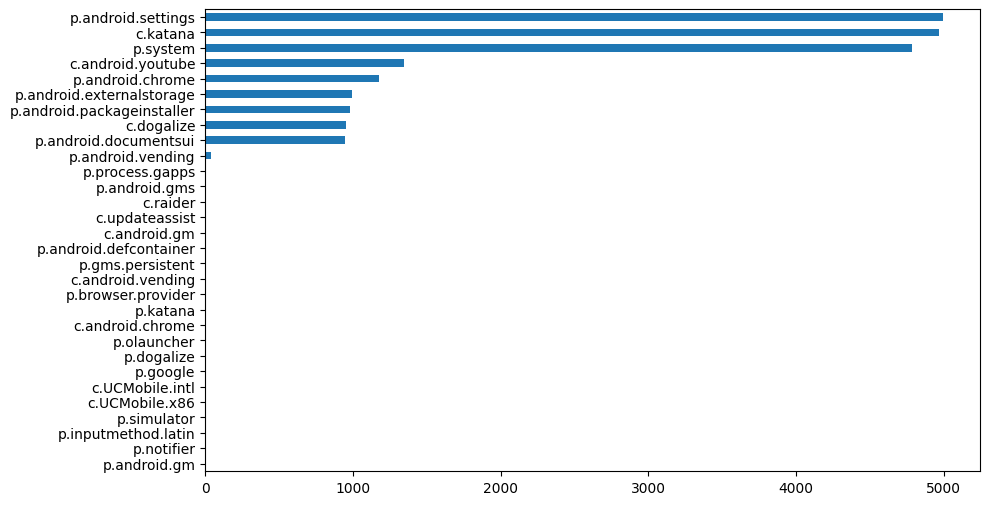

In [33]:
selector = f_classif(X, y)
X_tmp = pd.Series(selector[0], index=X.columns).sort_values(ascending=False)
X_tmp

plt.figure(figsize=(10, 6))
X_tmp.plot(kind="barh")
plt.gca().invert_yaxis()
plt.show()

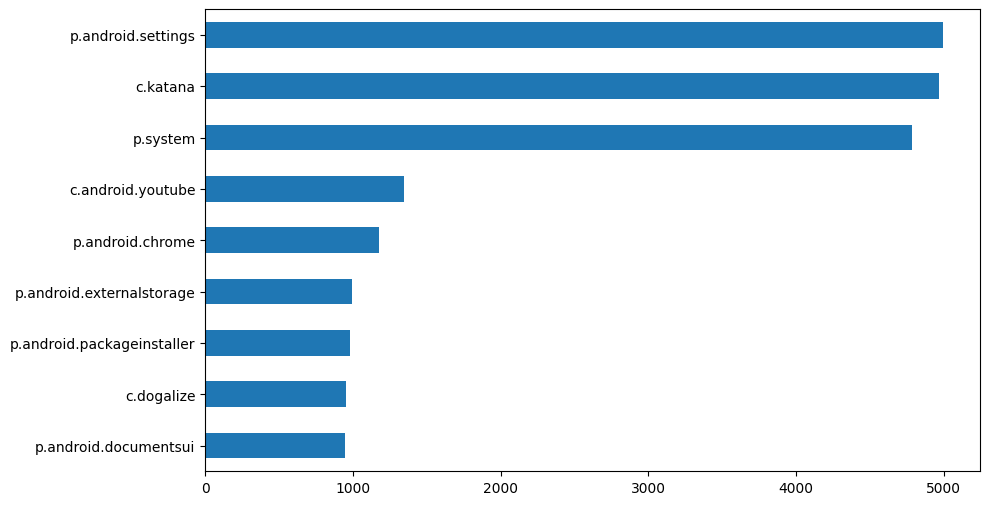

,0
p.android.settings,4996.171414
c.katana,4966.530109
p.system,4782.911547
c.android.youtube,1342.429632
p.android.chrome,1178.087352
p.android.externalstorage,995.062942
p.android.packageinstaller,977.908258
c.dogalize,952.567379
p.android.documentsui,947.343081


In [34]:
selector = f_classif(X, y)
X_tmp = pd.Series(selector[0], index=X.columns).sort_values(ascending=False)
X_tmp = X_tmp[X_tmp > 900]

plt.figure(figsize=(10, 6))
X_tmp.plot(kind="barh")
plt.gca().invert_yaxis()
plt.show()

pd.DataFrame(X_tmp)

-   We got these features as best:
    -   **p.android.settings**, **c.katana**, **p.system**, **c.android.youtube**, **p.android.chrome**, **p.android.externalstorage**, **p.android.packageinstaller**, **c.dogalize**, **p.android.documentsui**
-   Now we see a little bit more difference between MI and F-statistic, as we got 2 extra features


### SelectFromModel


In [51]:
selector = SelectFromModel(estimator=LogisticRegression(max_iter=1000, random_state=42))
_ = selector.fit_transform(X, y)
mask = selector.get_support()
selected_columns = X.columns[mask]
importance = np.abs(selector.estimator_.coef_[0][mask])

selected_features = pd.DataFrame({"Feature": selected_columns, "Importance": importance})

sorted_features = selected_features.sort_values(by="Importance", ascending=False).reset_index(drop=True)
sorted_features

,Feature,Importance
0,c.katana,0.393227
1,p.system,0.363154
2,p.android.settings,0.361432
3,p.android.vending,0.188788
4,c.android.youtube,0.157226
5,c.android.gm,0.108688
6,p.android.externalstorage,0.094568
7,c.dogalize,0.082831
8,p.android.gm,0.074950


In [50]:
selector = SelectFromModel(estimator=LinearSVC(random_state=42))
_ = selector.fit_transform(X, y)
mask = selector.get_support()
selected_columns = X.columns[mask]
importance = np.abs(lsvc.coef_[0][mask])

selected_features = pd.DataFrame({"Feature": selected_columns, "Importance": importance})

selected_features = selected_features.sort_values(by="Importance", ascending=False).reset_index(drop=True)
selected_features

,Feature,Importance
0,p.android.settings,0.127280
1,c.katana,0.122960
2,p.system,0.118086
3,p.android.vending,0.089338
4,c.android.youtube,0.053559
5,c.android.gm,0.033687
6,c.dogalize,0.032900
7,p.android.gm,0.030026
8,p.android.externalstorage,0.028613


In [52]:
model = SelectFromModel(estimator=RandomForestClassifier(random_state=42))
_ = model.fit_transform(X, y)

selected_columns = X.columns[model.get_support()]
importance = model.estimator_.feature_importances_
selected_features = pd.DataFrame({"Feature": selected_columns, "Importance": importance[model.get_support()]})

selected_features = selected_features.sort_values(by="Importance", ascending=False).reset_index(drop=True)
selected_features

,Feature,Importance
0,c.katana,0.152602
1,p.android.settings,0.152552
2,p.system,0.139513
3,c.android.youtube,0.073481
4,c.dogalize,0.047061
5,p.android.chrome,0.046374
6,p.android.packageinstaller,0.043927
7,p.android.externalstorage,0.035237


## B

### **Zadanie:** Zoraďte zistené atribúty v poradí podľa dôležitosti.


## C

### **Zadanie:** Zdôvodnite Vaše voľby/rozhodnutie pre realizáciu (t.j. zdokumentovanie)


# 2.3


## A

### **Zadanie:** Upravte váš kód realizujúci predspracovanie trénovacej množiny tak, aby ho bolo možné bez ďalších úprav znovu použiť na predspracovanie testovacej množiny v kontexte strojového učenia.


## B

### **Zadanie:** Využite možnosti sklearn.pipeline
